# Insurance for classification

## Problem description

Your task is to apply various ML algorithms (see the rules below) to build a model explaining travel insurance claim outcomes based on the training sample and generate predictions for all observations from the test sample.

The dataset includes travel insurance policy records with the following columns:

- reward – Commission value earned on the insurance sale

- claim_status – Target variable (0 = Not Approved, 1 = Approved) Only in training sample

- person_gender – Gender identifier of the insured person

- entity_type – Type of selling entity

- channel – Distribution channel used

- support_interactions – Number of customer service interactions

- agent_id – Identifier for the selling agent

- customer_score – Computed value between 0-1 based on customer metrics

- entity_a – Identifier of the agency that sold the policy

- person_age – Age of the insured person

- location – Destination of the trip

- revenue – Net sales value of the policy (when <0 it covers discounts)

- product_id – Name of the insurance product

- trip_length – Duration of the insured trip in days

## File description

- insurance_train.csv – training data contains 56993 observations and 14 columns along with the target variable claim_status

- insurance_test.csv – test data contains 6333 observations and 13 columns without the target variable

## Requirements

### Exploratory Data Analysis:
- Analyze the dataset to identify key patterns, correlations, and potential challenges introduced by the additional variables.
- Visualize distributions and relationships among variables.
### Feature Engineering:
- Consider transformation or scaling of variables as needed. 
- Evaluate the impact of the supplementary variables on model performance.
### Modeling:
- Build, train, and compare multiple regression models. 
- Optimize model hyperparameters using cross-validation.
### Predictions:
- Generate predictions for all observations in the test dataset. 
- Document model performance and reasoning behind the selected approach.
### Documentation:
- Provide a clear explanation of your analysis, modeling choices, and any challenges faced while integrating the additional variables.
## Various algorithms
For each of the datasets please consider and compare at least 3 different ML algorithms discussed in the ML1 course (e.g. linear/logistic regression, KNN, LASSO, ridge, elastic net, SVM/SVR with various kernel functions). You can also apply in addition any other algorithms you know, but they cannot be used instead of the ones mentioned before.

## Selection of the best algorithm
The choice of the final algorithm applied to generate predictions should be clearly explained in the presentation.

HINT !!!!! Use the internal division of the training data into train/validation/test samples to make sure that you correcly assess the performance of your models on the new data.

## Performance measure
The performance of predictions will be based on:

RMSE for the appartments dataset
balanced accuracy for the insurance dataset
Please report the expected value of a particular performance measure (expectation for the test sample) in your presentation.

## Dependencies loading

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pathlib import Path

pd.set_option("display.max_columns", 500)

np.random.seed(2115) #uncomment if you want your code to be reproducible; for the purposes of our activity, let's add some randomness to the results

## Project setup

In [3]:
raw_input_data_path = r"C:\Users\wojci\Desktop\Machine Learning\MachineLearning1\Insurances\data_input"
preprocessed_output_data_path = r"C:\Users\wojci\Desktop\Machine Learning\MachineLearning1\Insurances\data_output"

## Data preparation

### Data loading

In [4]:
df = pd.read_csv(f"{raw_input_data_path}/insurance_train.csv")

In [5]:
df.sample(10)

,reward,claim_status,person_gender,entity_type,channel,support_interactions,agent_id,customer_score,entity_a,person_age,location,revenue,product_id,trip_length
38941,3.490289,0,9b2d5b46,type_b,web,1,agt_0008,0.120951,b5e4bb23,48,singapore,12.400049,TripGuard TicketCover,66
25469,49.421638,0,9b2d5b46,type_a,web,1,agt_0001,0.275306,96d6c6df,44,italy,83.093531,DriveSafe Rental Addon,28
10106,54.310570,0,f67ab10a,type_b,web,2,agt_0005,0.369333,99ede4e4,42,singapore,223.247602,SecurePlan Annual Lite,374
51020,13.496401,0,f67ab10a,type_b,web,0,agt_0005,0.109287,99ede4e4,26,singapore,56.071373,TravelShield Plus,36
54192,0.000000,0,9b2d5b46,type_a,web,0,agt_0004,0.226950,50b3e71e,38,israel,26.841574,SecurePlan Flex,32
3803,2.818914,0,f67ab10a,type_b,web,1,agt_0005,0.238494,99ede4e4,30,singapore,11.745844,TravelShield Core,6
1109,16.148170,0,08f27188,type_b,web,1,agt_0005,0.243082,99ede4e4,46,singapore,62.043173,TravelShield Plus,16
26755,0.000000,0,9b2d5b46,type_a,web,1,agt_0004,0.196204,50b3e71e,36,italy,46.905613,TripGuard Cancel,48
29232,0.000000,0,9b2d5b46,type_a,web,2,agt_0004,0.041296,50b3e71e,30,thailand,10.244600,TripGuard Cancel,33
22074,0.000000,0,9b2d5b46,type_a,web,2,agt_0004,0.141518,50b3e71e,35,spain,9.802957,TripGuard Cancel,99


### Dataset adjustment

In [6]:
df.columns

Index(['reward', 'claim_status', 'person_gender', 'entity_type', 'channel',
       'support_interactions', 'agent_id', 'customer_score', 'entity_a',
       'person_age', 'location', 'revenue', 'product_id', 'trip_length'],
      dtype='object')

In [7]:
df.select_dtypes(include='object').nunique().to_frame()

,0
person_gender,3
entity_type,2
channel,2
agent_id,16
entity_a,16
location,146
product_id,26


##### Checking if every variable has proper type

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56993 entries, 0 to 56992
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reward                56993 non-null  float64
 1   claim_status          56993 non-null  int64  
 2   person_gender         56993 non-null  object 
 3   entity_type           56993 non-null  object 
 4   channel               56993 non-null  object 
 5   support_interactions  56993 non-null  int64  
 6   agent_id              56993 non-null  object 
 7   customer_score        56993 non-null  float64
 8   entity_a              56993 non-null  object 
 9   person_age            56993 non-null  int64  
 10  location              56993 non-null  object 
 11  revenue               56993 non-null  float64
 12  product_id            56993 non-null  object 
 13  trip_length           56993 non-null  int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 6.1+ MB


In [9]:
missing_percent = (df.isna().sum() / len(df) * 100).round(2)
print(missing_percent)

reward                  0.0
claim_status            0.0
person_gender           0.0
entity_type             0.0
channel                 0.0
support_interactions    0.0
agent_id                0.0
customer_score          0.0
entity_a                0.0
person_age              0.0
location                0.0
revenue                 0.0
product_id              0.0
trip_length             0.0
dtype: float64


We don't have any columns with missing values, so we can keep the data as it is.

In [10]:
print(df.describe())

             reward  claim_status  support_interactions  customer_score  \
count  56993.000000  56993.000000          56993.000000    56993.000000   
mean       9.794976      0.014633              1.093941        0.189540   
std       19.791119      0.120081              0.923113        0.080641   
min        0.000000      0.000000              0.000000        0.000000   
25%        0.000000      0.000000              0.000000        0.136389   
50%        0.000000      0.000000              1.000000        0.181041   
75%       11.336612      0.000000              2.000000        0.230836   
max      282.073580      1.000000              6.000000        1.000000   

         person_age       revenue   trip_length  
count  56993.000000  56993.000000  56993.000000  
mean      39.697261     40.750070     49.234888  
std       12.603433     48.749221     98.659469  
min       18.000000   -406.642669      1.000000  
25%       34.000000     18.246389      9.000000  
50%       36.000000     

In [11]:
# Finding how many records with negative revenue or reward we have and how big percentage of the dataset it is
print(df[(df['revenue'] < 0) | (df['reward'] < 0)].shape[0] / df.shape[0] * 100)
print(df[(df['revenue'] < 0) | (df['reward'] < 0)].shape[0])

1.0527608653694314
600


In [12]:
#Removing data with negative revenue or reward
df = df[(df['revenue'] >= 0) & (df['reward'] >= 0)]

Distribution of claim_status:
              Count  Percentage
claim_status                   
0             55561       98.52
1               832        1.48


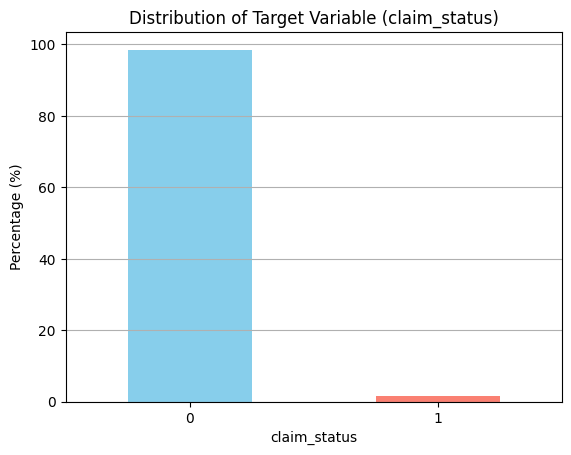

In [13]:
# Distribution of target variable (claim_status)
claim_counts = df['claim_status'].value_counts()
claim_percent = df['claim_status'].value_counts(normalize=True) * 100

# Tworzenie tabeli
claim_distribution = pd.DataFrame({
    'Count': claim_counts,
    'Percentage': claim_percent.round(2)
})
print("Distribution of claim_status:")
print(claim_distribution)

# Wykres
claim_distribution['Percentage'].plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Target Variable (claim_status)')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

We clearly see that we only have 1,46% of the data with claim_status = 1, so we have to deal with a very unbalanced dataset. We can use SMOTE to balance the dataset in the modeling phase.

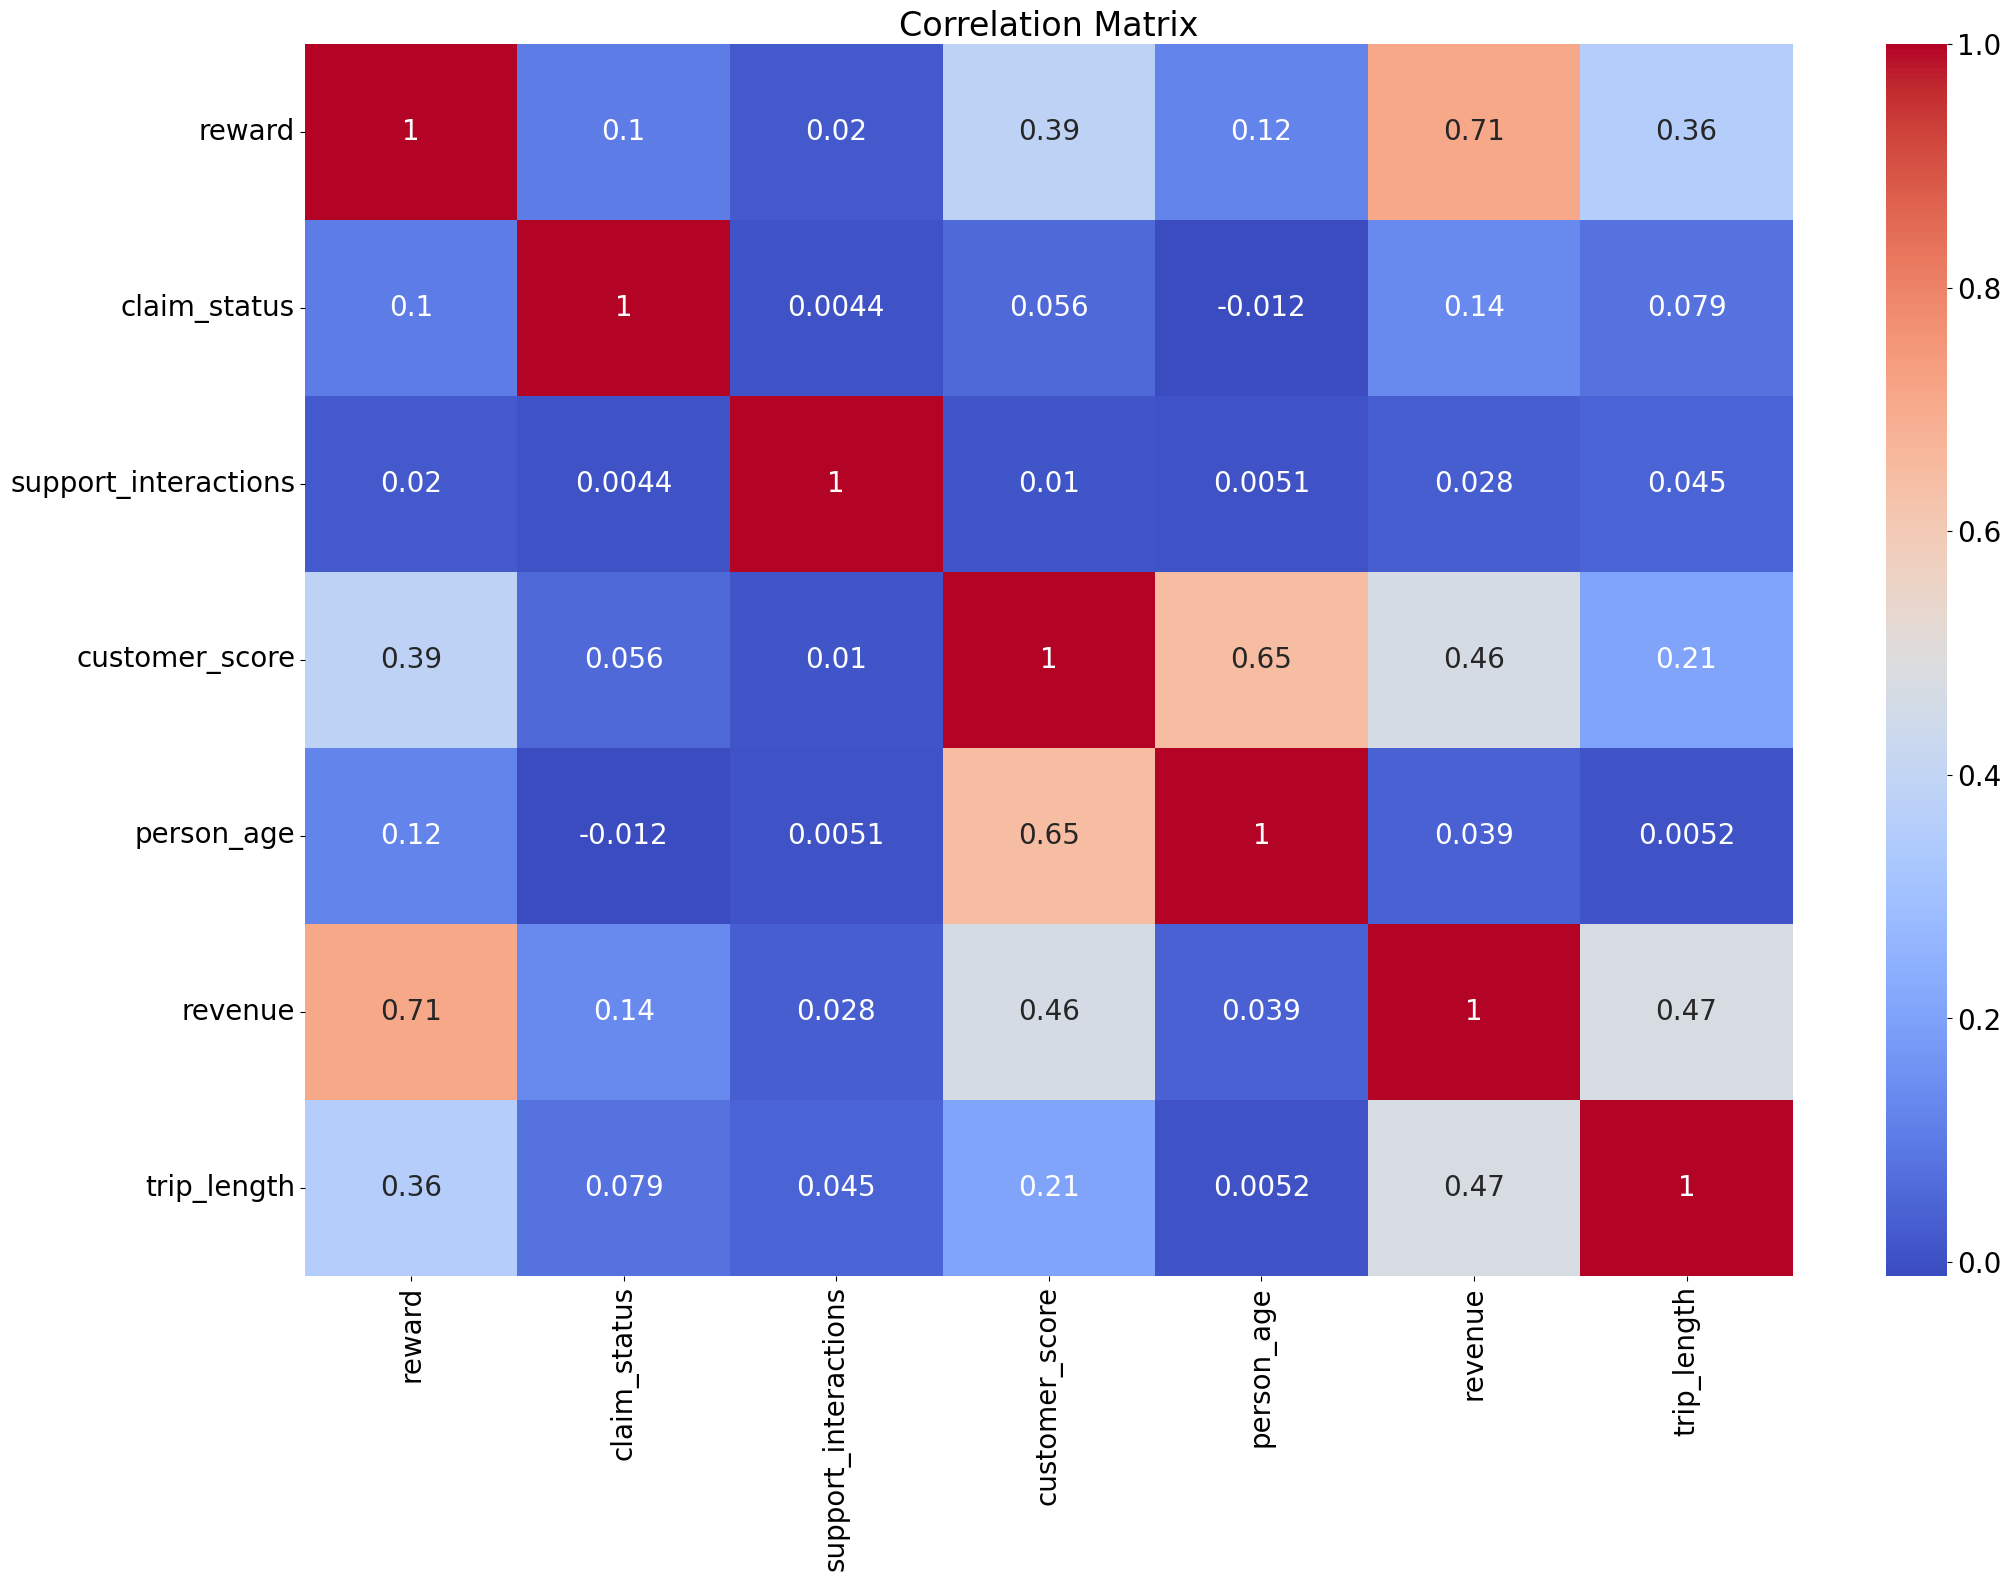

In [14]:
corr_columns = df.select_dtypes(include=[np.number])
plt.rcParams['font.size'] = 20
plt.figure(figsize=(24, 16))
sns.heatmap(corr_columns.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

I can see a correlation between revenue and reward and between person_age and customer score

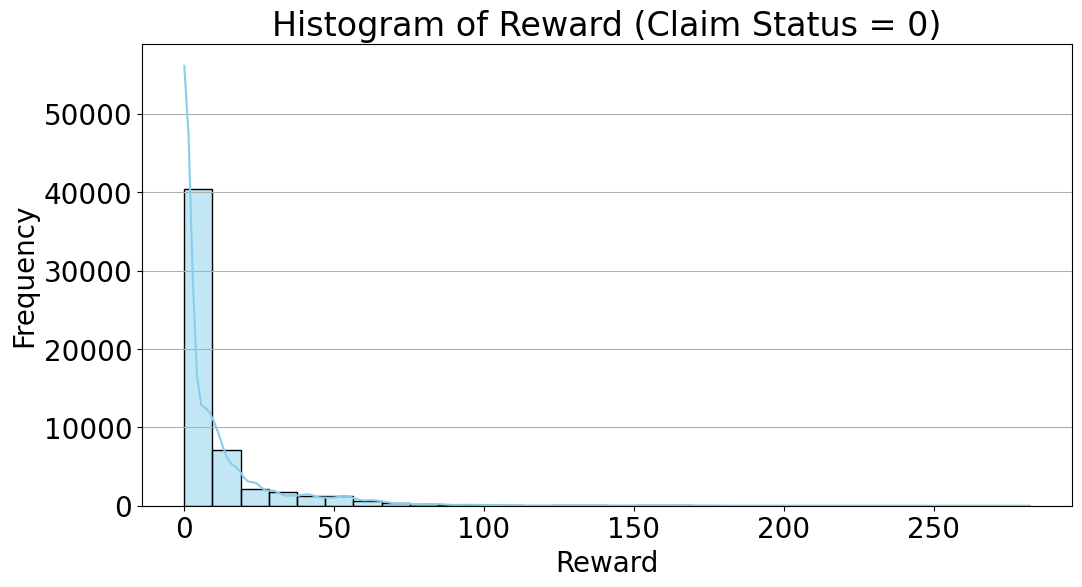

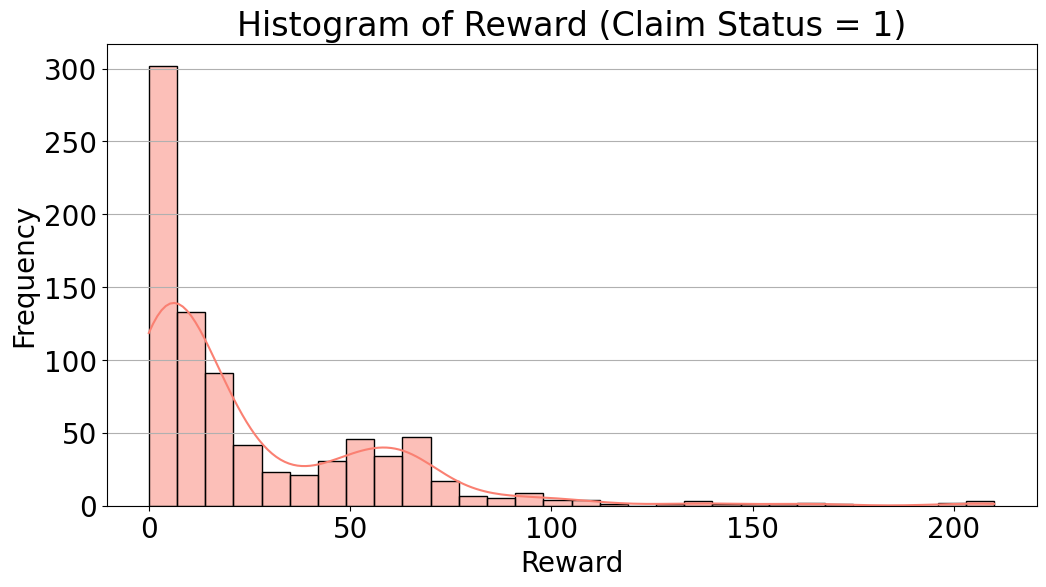

In [15]:
#Reward values on histogram - 2 separate plots by claim status
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 0], x='reward', bins=30, kde=True, color='skyblue')
plt.title('Histogram of Reward (Claim Status = 0)')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 1], x='reward', bins=30, kde=True, color='salmon')
plt.title('Histogram of Reward (Claim Status = 1)')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

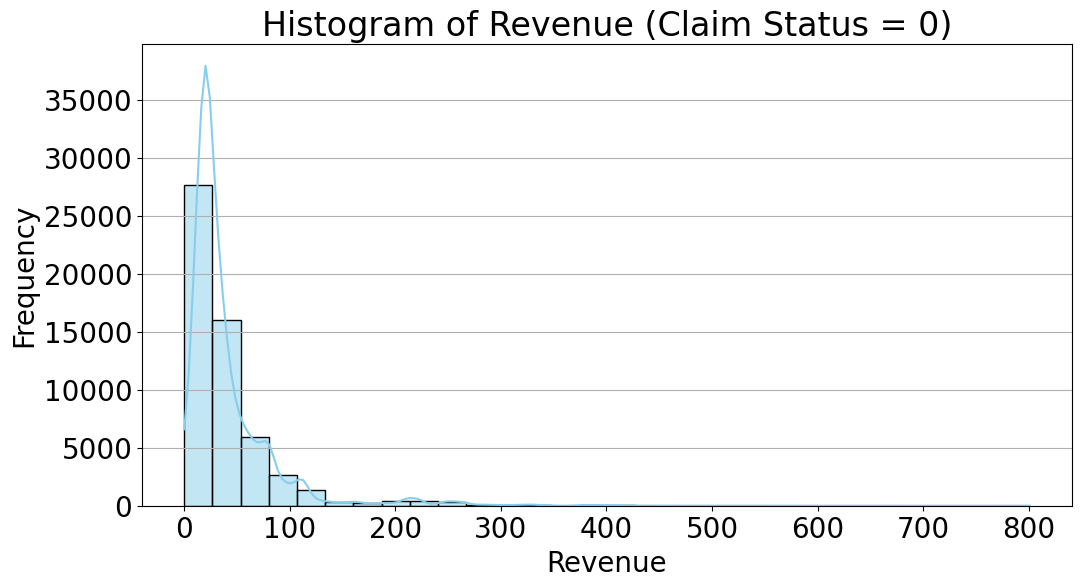

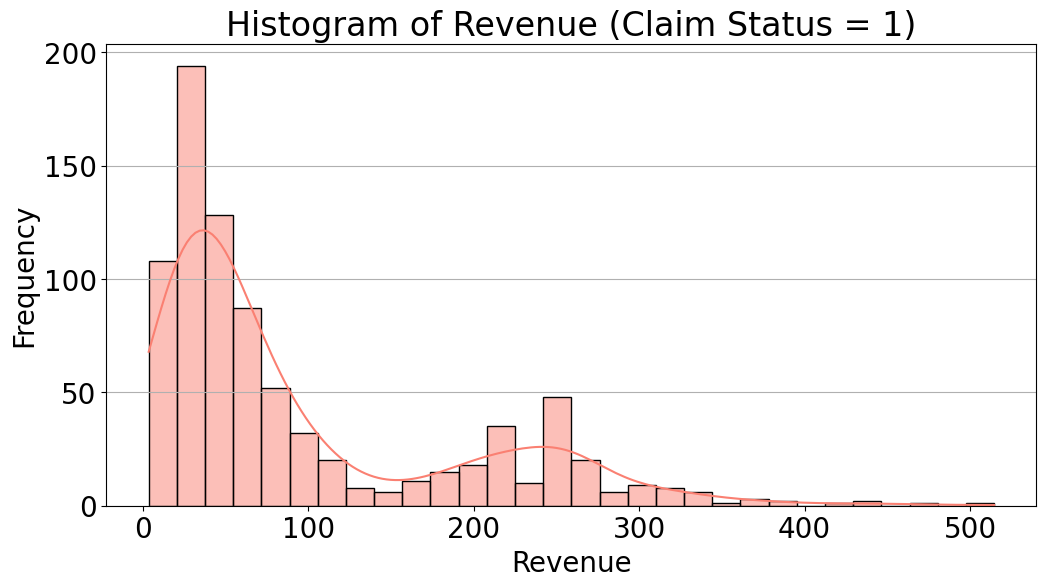

In [16]:
#Revenue values on histogram - 2 separate plots by claim status
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 0], x='revenue', bins=30, kde=True, color='skyblue')
plt.title('Histogram of Revenue (Claim Status = 0)')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 1], x='revenue', bins=30, kde=True, color='salmon')
plt.title('Histogram of Revenue (Claim Status = 1)')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

Distribution of reward and revenue is very skewed, so we can use log transformation to make it more normal.

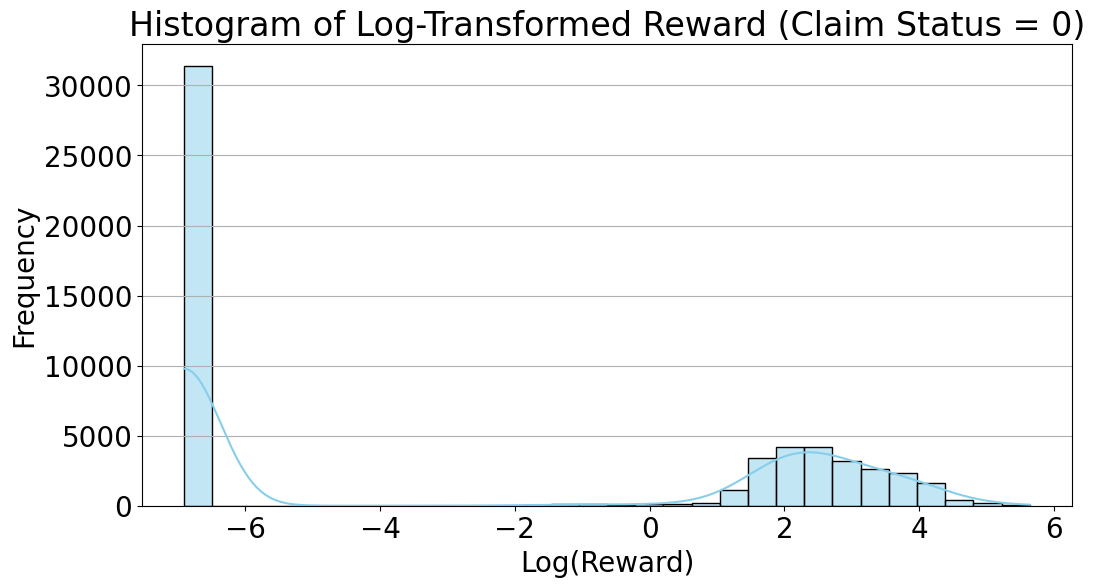

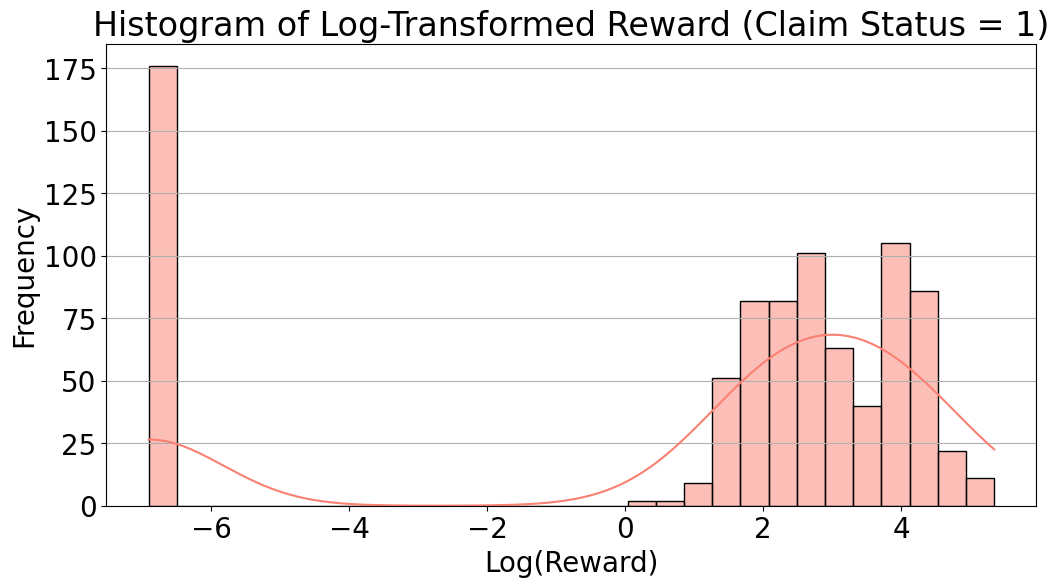

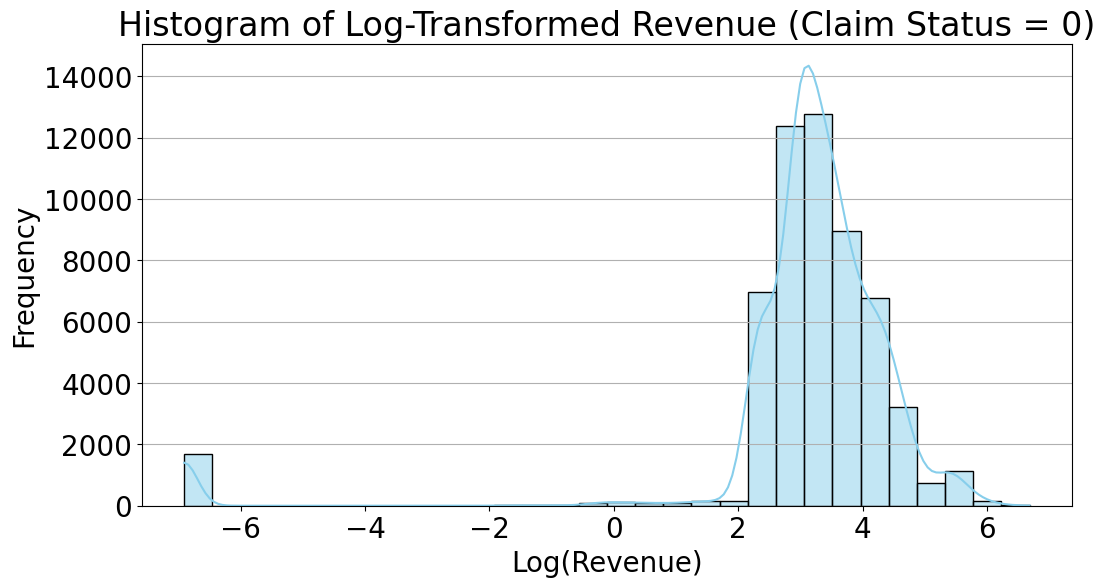

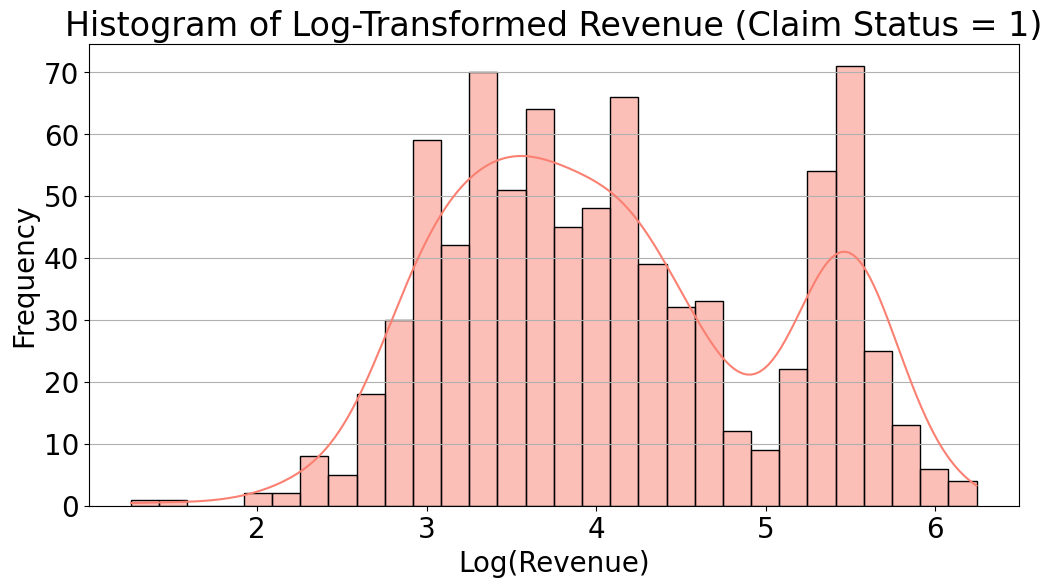

In [17]:
#Logging the revenue variable
df['log_revenue'] = np.log(df['revenue'].replace(0, 0.001))
#Logging the reward variable
df['log_reward'] = np.log(df['reward'].replace(0, 0.001))
#Plotting the log-transformed variables - separate plots by claim status
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 0], x='log_reward', bins=30, kde=True, color='skyblue')
plt.title('Histogram of Log-Transformed Reward (Claim Status = 0)')
plt.xlabel('Log(Reward)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 1], x='log_reward', bins=30, kde=True, color='salmon')
plt.title('Histogram of Log-Transformed Reward (Claim Status = 1)')
plt.xlabel('Log(Reward)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 0], x='log_revenue', bins=30, kde=True, color='skyblue')
plt.title('Histogram of Log-Transformed Revenue (Claim Status = 0)')
plt.xlabel('Log(Revenue)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 1], x='log_revenue', bins=30, kde=True, color='salmon')
plt.title('Histogram of Log-Transformed Revenue (Claim Status = 1)')
plt.xlabel('Log(Revenue)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

Now the distribution of reward and revenue looks much better. We also see that both distributions look very similar, which was potentially expected as we have a connection between commission value earned on sale and net sales value of policy.


Analiza zmiennej: person_gender


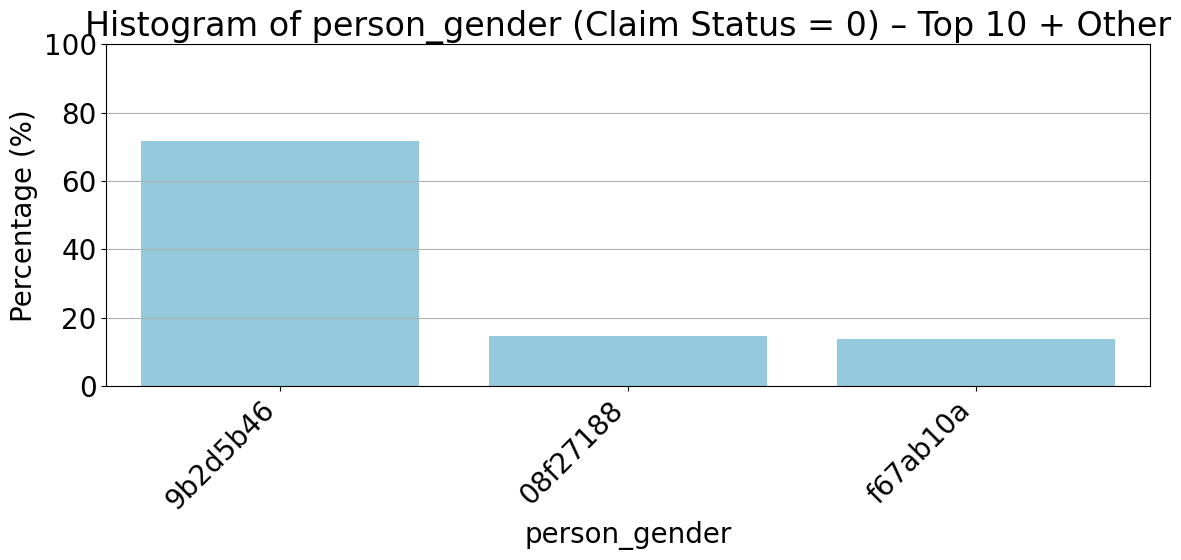

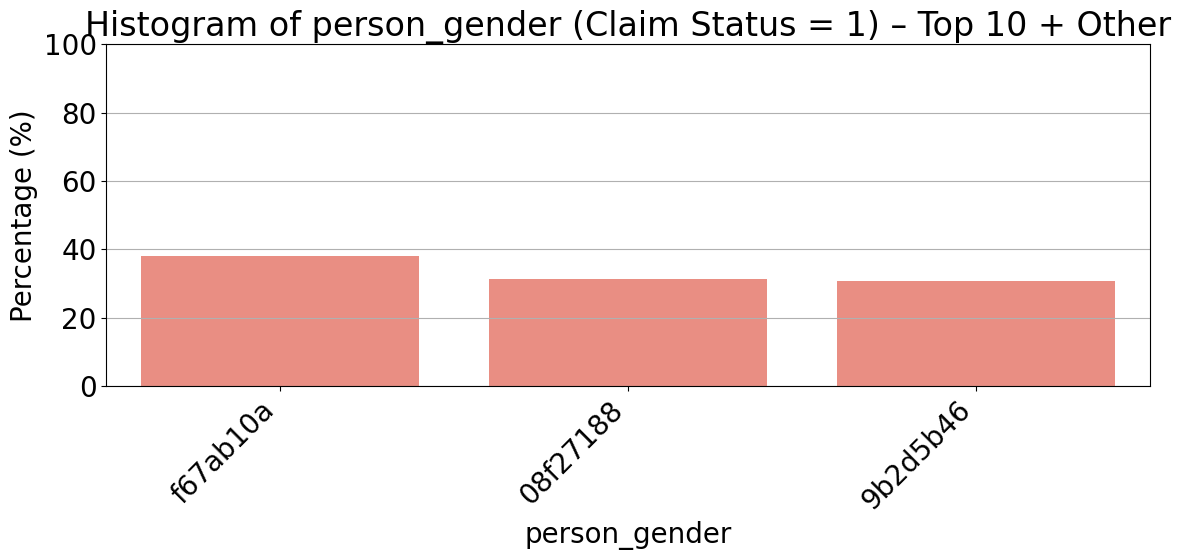

Distribution of person_gender (Claim Status = 0):
               Count  Percentage
person_gender                   
9b2d5b46       39879       71.78
08f27188        8073       14.53
f67ab10a        7609       13.69
Distribution of person_gender (Claim Status = 1):
               Count  Percentage
person_gender                   
f67ab10a         316       37.98
08f27188         261       31.37
9b2d5b46         255       30.65

Analiza zmiennej: entity_type


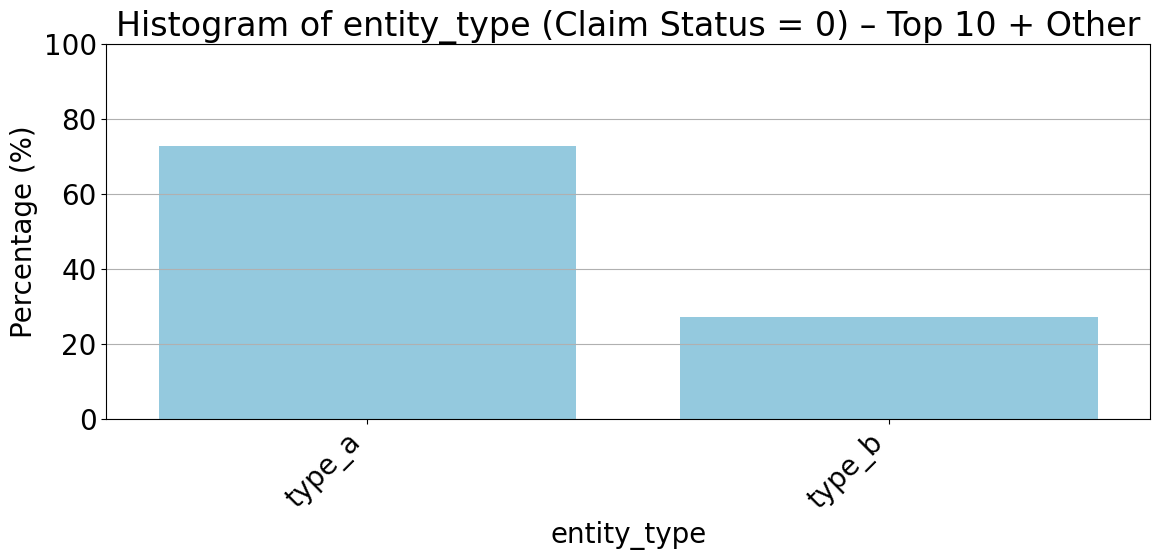

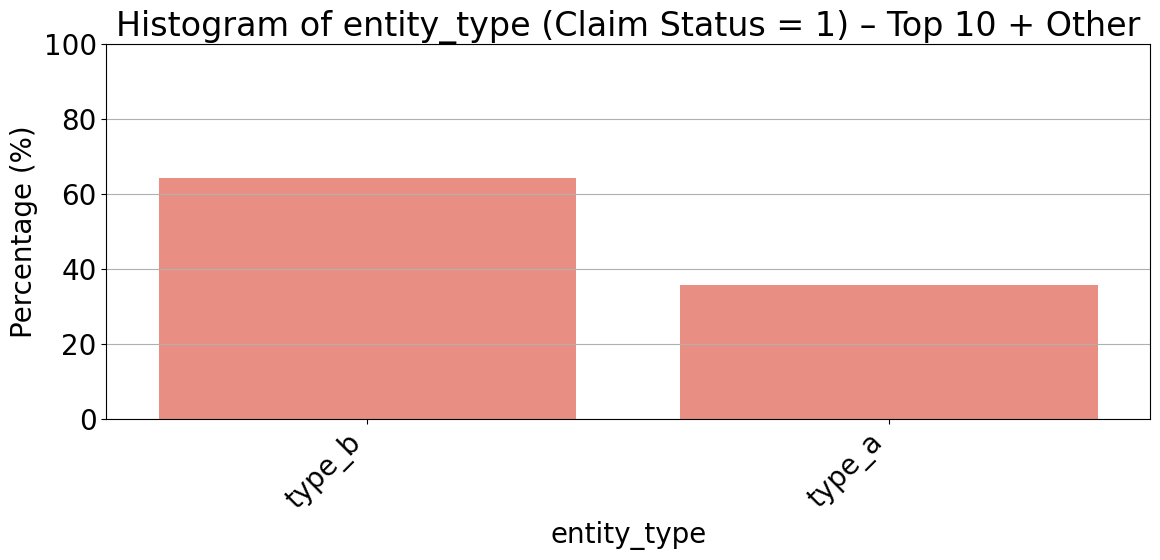

Distribution of entity_type (Claim Status = 0):
             Count  Percentage
entity_type                   
type_a       40481       72.86
type_b       15080       27.14
Distribution of entity_type (Claim Status = 1):
             Count  Percentage
entity_type                   
type_b         535        64.3
type_a         297        35.7

Analiza zmiennej: channel


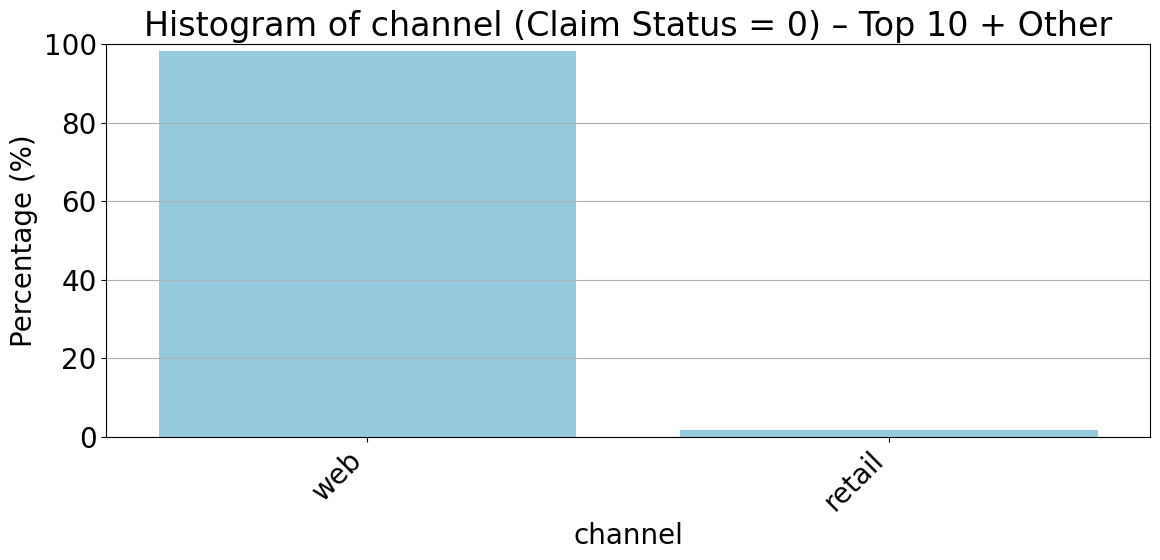

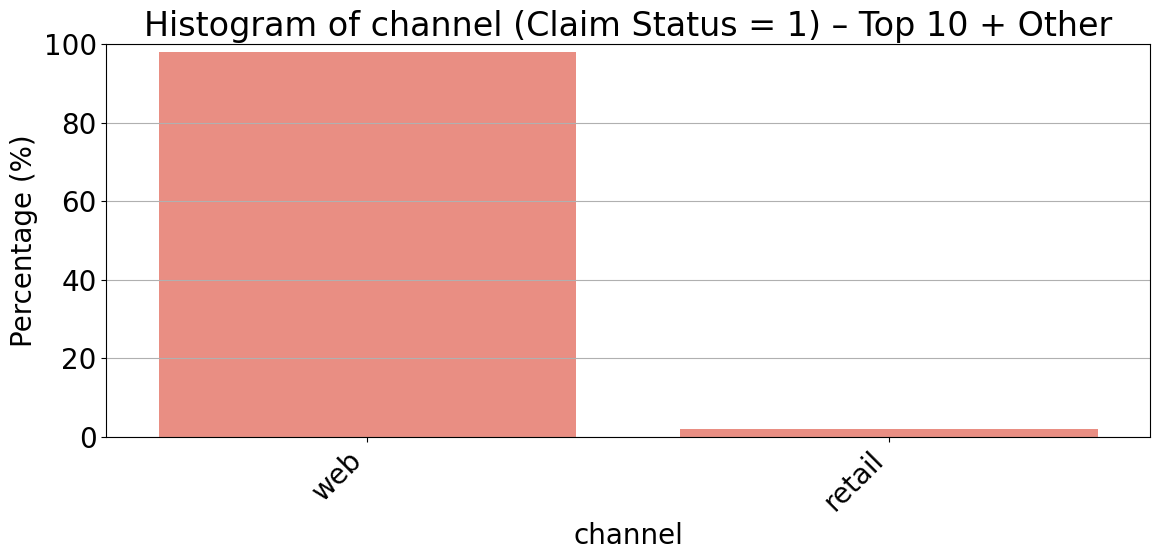

Distribution of channel (Claim Status = 0):
         Count  Percentage
channel                   
web      54609       98.29
retail     952        1.71
Distribution of channel (Claim Status = 1):
         Count  Percentage
channel                   
web        816       98.08
retail      16        1.92

Analiza zmiennej: agent_id


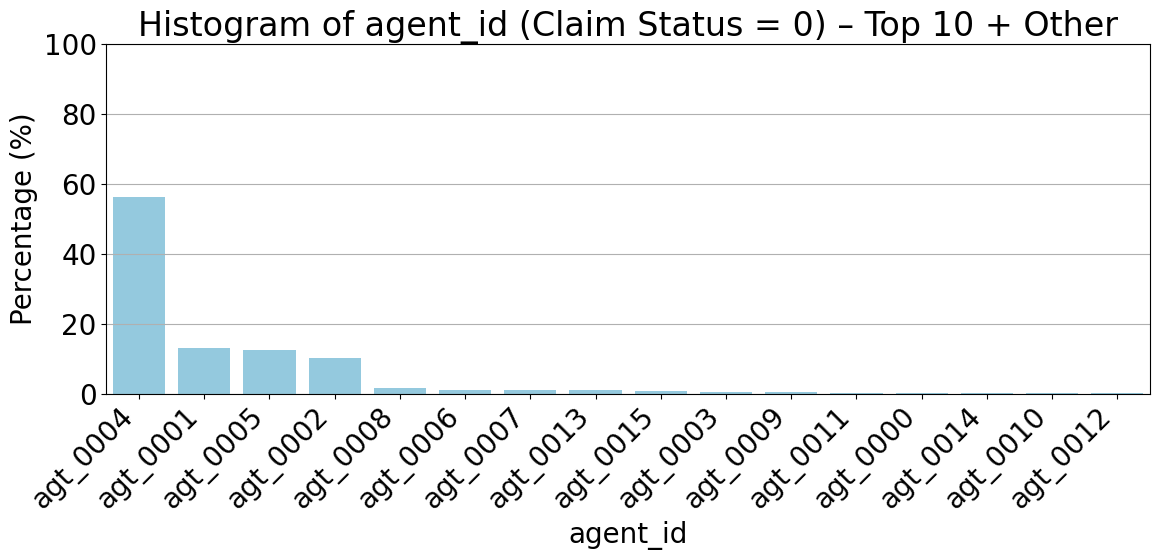

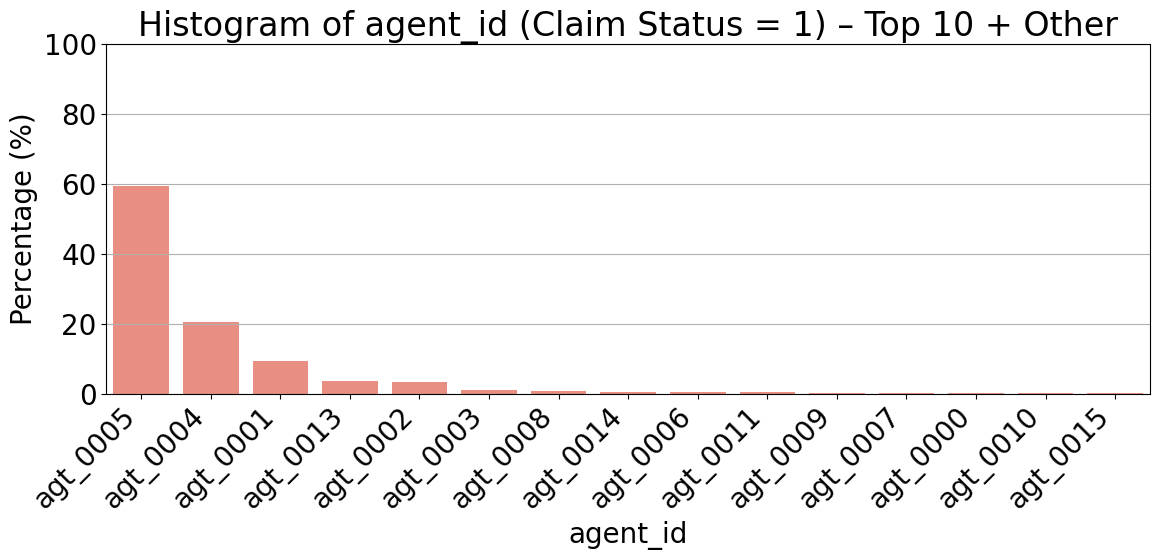

Distribution of agent_id (Claim Status = 0):
          Count  Percentage
agent_id                   
agt_0004  31323       56.38
agt_0001   7311       13.16
agt_0005   6913       12.44
agt_0002   5627       10.13
agt_0008    939        1.69
Other       763        1.37
agt_0006    663        1.19
agt_0007    648        1.17
agt_0013    576        1.04
agt_0015    453        0.82
agt_0003    345        0.62
Distribution of agent_id (Claim Status = 1):
          Count  Percentage
agent_id                   
agt_0005    494       59.38
agt_0004    172       20.67
agt_0001     77        9.25
agt_0013     30        3.61
agt_0002     29        3.49
agt_0003      8        0.96
agt_0008      6        0.72
Other         5        0.60
agt_0006      4        0.48
agt_0014      4        0.48
agt_0011      3        0.36

Analiza zmiennej: entity_a


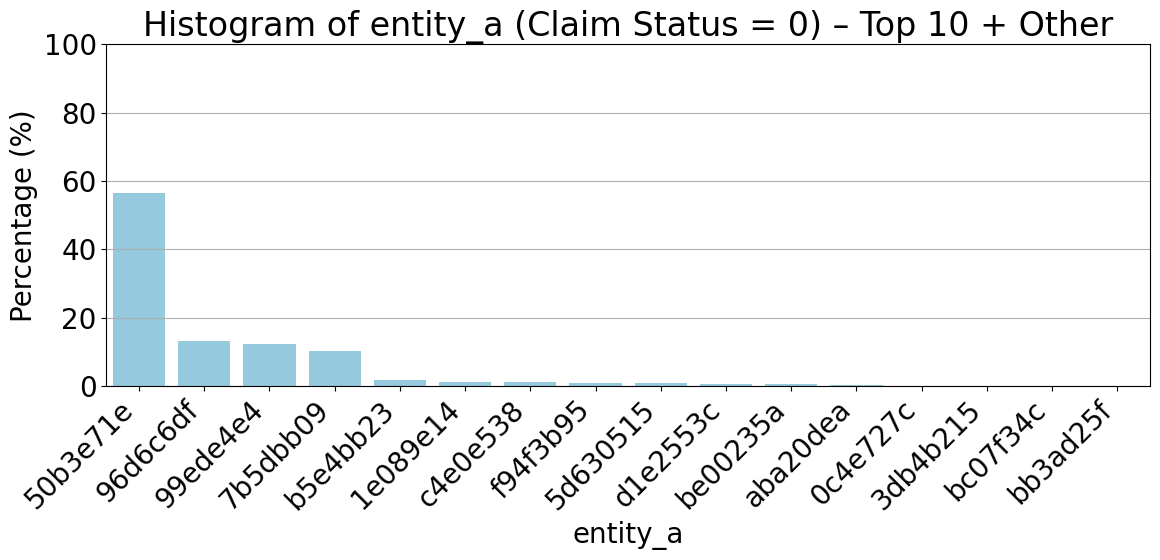

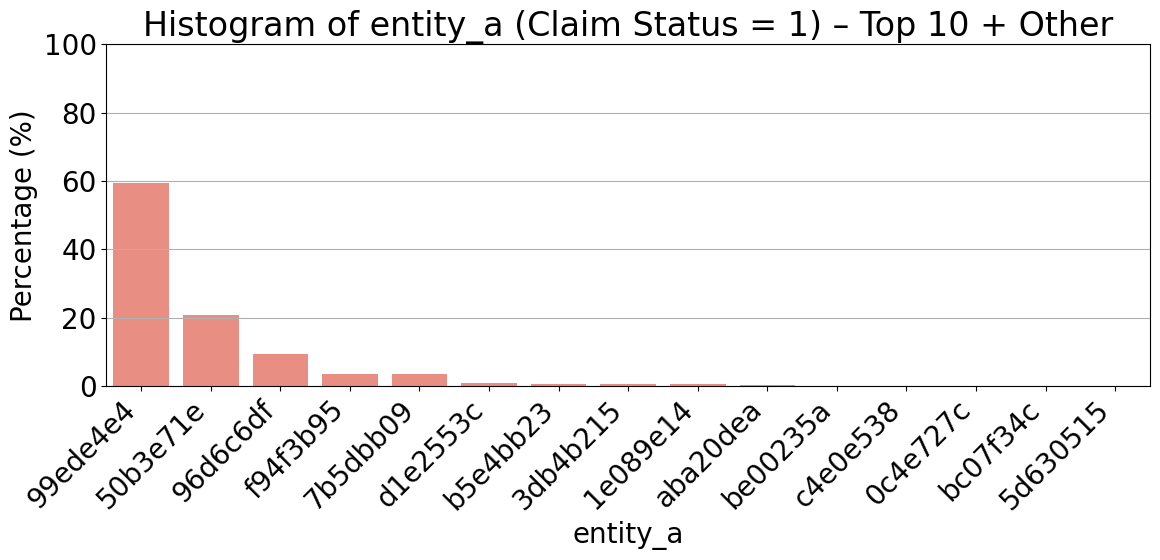

Distribution of entity_a (Claim Status = 0):
          Count  Percentage
entity_a                   
50b3e71e  31323       56.38
96d6c6df   7311       13.16
99ede4e4   6913       12.44
7b5dbb09   5627       10.13
b5e4bb23    939        1.69
Other       763        1.37
1e089e14    663        1.19
c4e0e538    648        1.17
f94f3b95    576        1.04
5d630515    453        0.82
d1e2553c    345        0.62
Distribution of entity_a (Claim Status = 1):
          Count  Percentage
entity_a                   
99ede4e4    494       59.38
50b3e71e    172       20.67
96d6c6df     77        9.25
f94f3b95     30        3.61
7b5dbb09     29        3.49
d1e2553c      8        0.96
b5e4bb23      6        0.72
Other         5        0.60
1e089e14      4        0.48
3db4b215      4        0.48
aba20dea      3        0.36

Analiza zmiennej: location


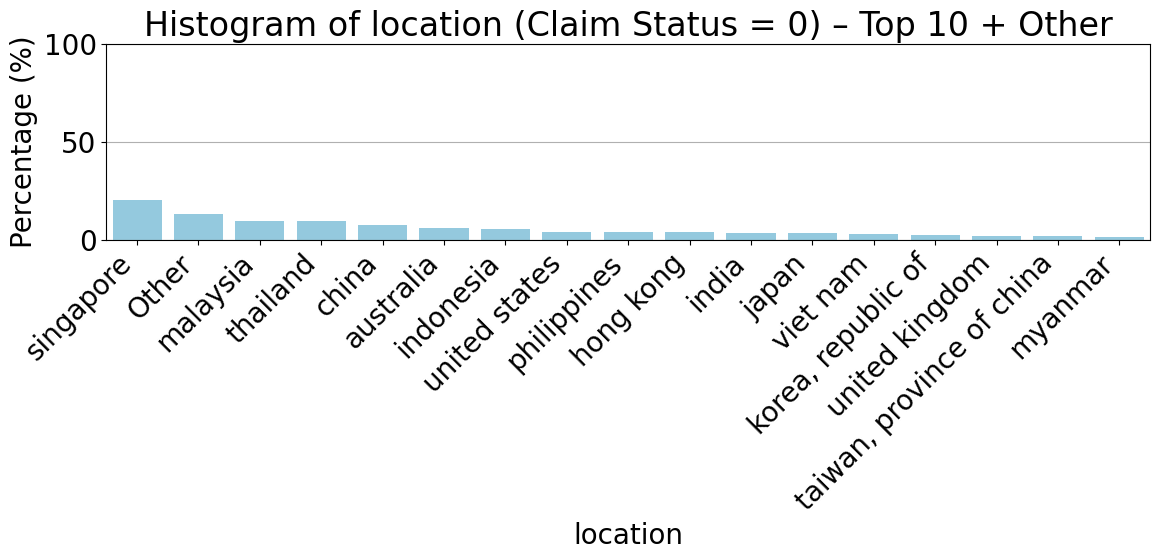

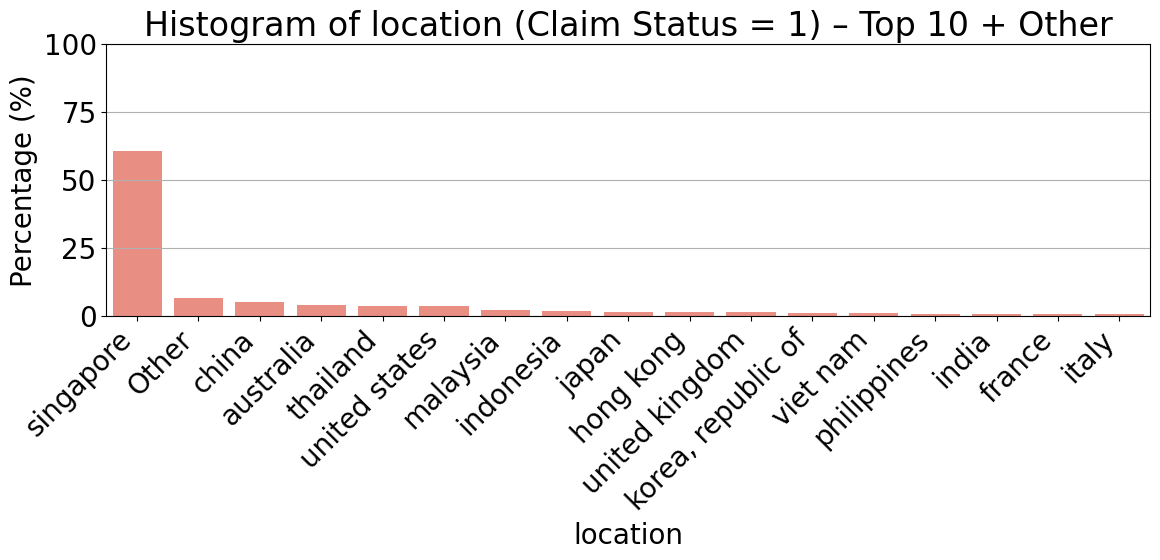

Distribution of location (Claim Status = 0):
               Count  Percentage
location                        
Other          14511       26.12
singapore      11371       20.47
malaysia        5288        9.52
thailand        5236        9.42
china           4274        7.69
australia       3189        5.74
indonesia       3081        5.55
united states   2231        4.02
philippines     2218        3.99
hong kong       2153        3.88
india           2009        3.62
Distribution of location (Claim Status = 1):
                Count  Percentage
location                         
singapore         506       60.82
Other             107       12.86
china              44        5.29
australia          34        4.09
united states      32        3.85
thailand           32        3.85
malaysia           20        2.40
indonesia          15        1.80
japan              14        1.68
hong kong          14        1.68
united kingdom     14        1.68

Analiza zmiennej: product_id


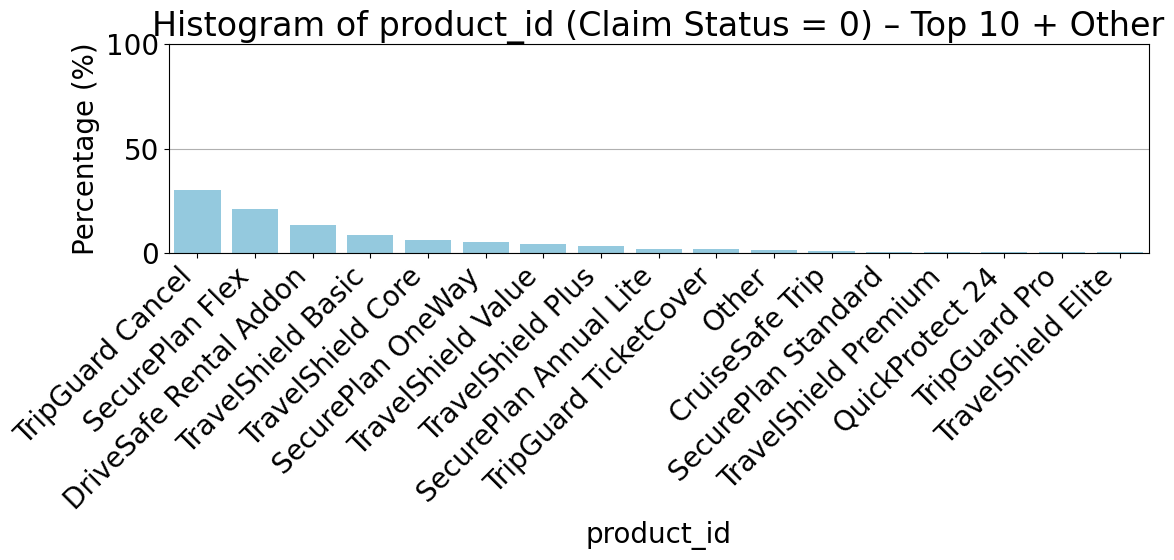

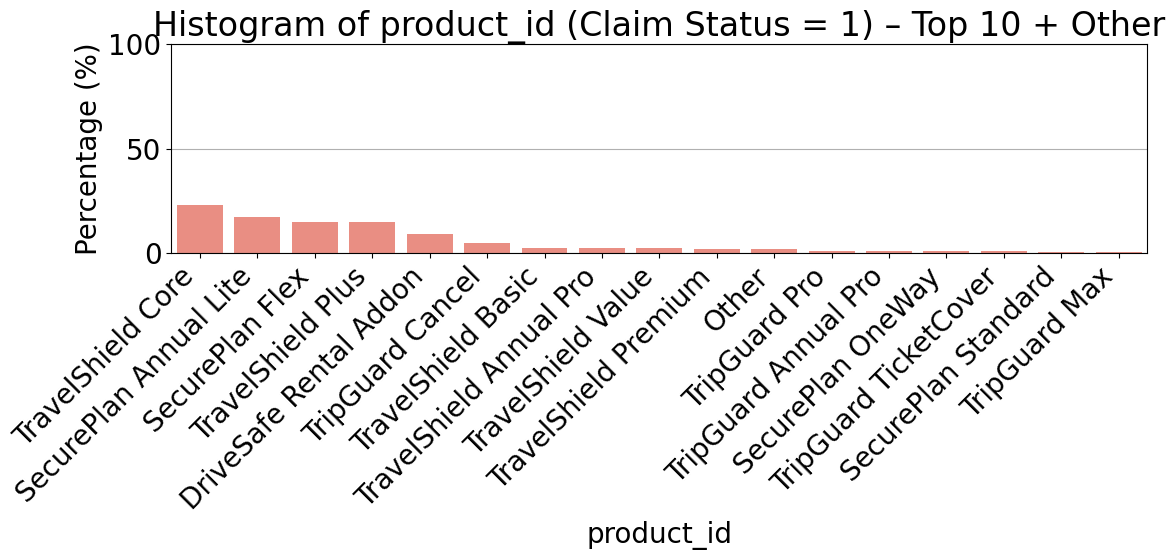

Distribution of product_id (Claim Status = 0):
                        Count  Percentage
product_id                               
TripGuard Cancel        16655       29.98
SecurePlan Flex         11692       21.04
DriveSafe Rental Addon   7311       13.16
TravelShield Basic       4873        8.77
TravelShield Core        3436        6.18
SecurePlan OneWay        2976        5.36
TravelShield Value       2393        4.31
Other                    2265        4.08
TravelShield Plus        1897        3.41
SecurePlan Annual Lite   1124        2.02
TripGuard TicketCover     939        1.69
Distribution of product_id (Claim Status = 1):
                         Count  Percentage
product_id                                
TravelShield Core          191       22.96
SecurePlan Annual Lite     143       17.19
SecurePlan Flex            125       15.02
TravelShield Plus          124       14.90
DriveSafe Rental Addon      77        9.25
Other                       57        6.85
TripGuard Cancel

In [18]:
# Wykresy i tabele dla wszystkich zmiennych typu object (kategorycznych) – top 10 + "Other" z sortowaniem słupków wg udziału %

object_cols = df.select_dtypes(include='object').columns

for col in object_cols:
    print(f"\n{'='*40}\nAnaliza zmiennej: {col}\n{'='*40}")

    # Przygotowanie danych: top 10 + "Other"
    def prepare_top10_other(series):
        top16 = series.value_counts(normalize=True).nlargest(16)
        mask = series.isin(top16.index)
        result = series.where(mask, other='Other')
        return result

    # claim_status = 0
    data0 = prepare_top10_other(df[df['claim_status'] == 0][col])
    data0_counts = data0.value_counts(normalize=True).mul(100).sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=data0_counts.index,
        y=data0_counts.values,
        color='skyblue'
    )
    plt.title(f'Histogram of {col} (Claim Status = 0) – Top 10 + Other')
    plt.xlabel(col)
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 100)
    plt.grid(axis='y')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # claim_status = 1
    data1 = prepare_top10_other(df[df['claim_status'] == 1][col])
    data1_counts = data1.value_counts(normalize=True).mul(100).sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=data1_counts.index,
        y=data1_counts.values,
        color='salmon'
    )
    plt.title(f'Histogram of {col} (Claim Status = 1) – Top 10 + Other')
    plt.xlabel(col)
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 100)
    plt.grid(axis='y')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Tabele zliczeń i procentów (top 10 + Other)
    def value_counts_top10_other(series):
        top10 = series.value_counts(normalize=False).nlargest(10)
        mask = series.isin(top10.index)
        grouped = series.where(mask, other='Other')
        counts = grouped.value_counts()
        percents = grouped.value_counts(normalize=True) * 100
        return pd.DataFrame({'Count': counts, 'Percentage': percents.round(2)})

    print(f"Distribution of {col} (Claim Status = 0):")
    print(value_counts_top10_other(df[df['claim_status'] == 0][col]))

    print(f"Distribution of {col} (Claim Status = 1):")
    print(value_counts_top10_other(df[df['claim_status'] == 1][col]))

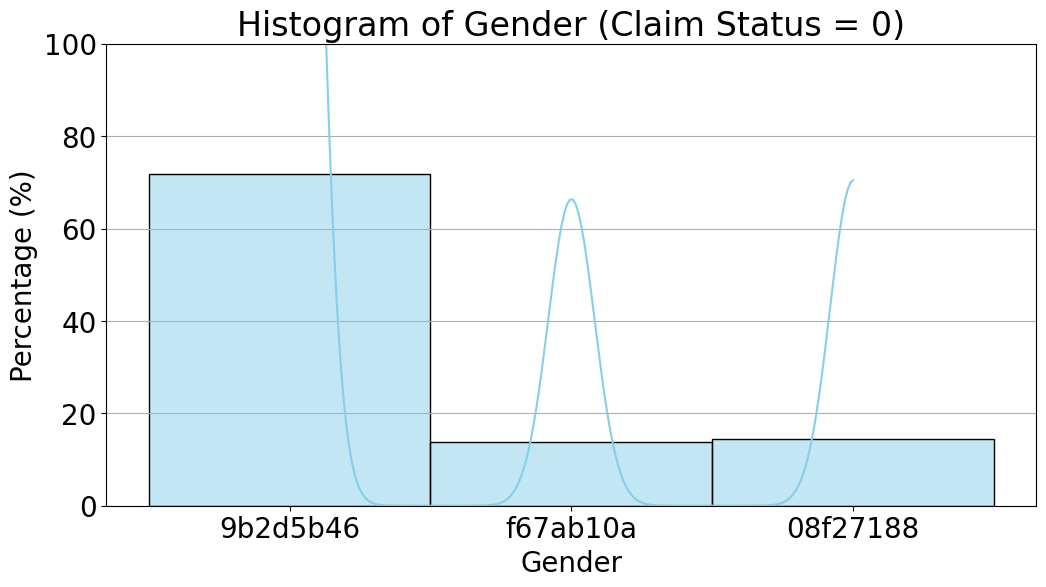

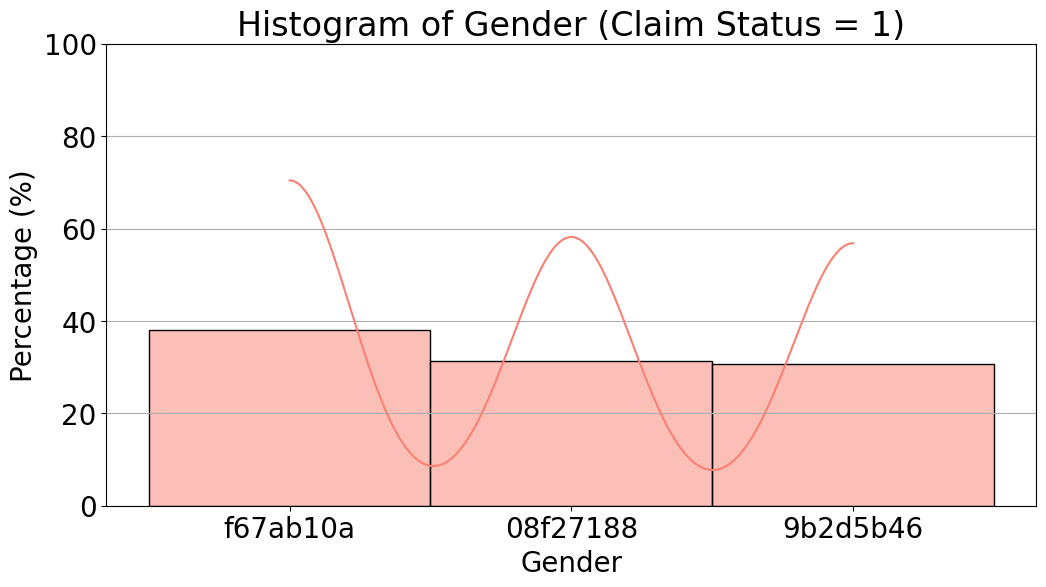

Distribution of gender (Claim Status = 0):
               Count  Percentage
person_gender                   
9b2d5b46       39879       71.78
08f27188        8073       14.53
f67ab10a        7609       13.69
Distribution of gender (Claim Status = 1):
               Count  Percentage
person_gender                   
f67ab10a         316       37.98
08f27188         261       31.37
9b2d5b46         255       30.65


In [19]:
# Distribution of gender variable - 2 separate plots by claim status - # Plotting by share percentage - percentage share on Y plot - scale Y to max 100% and 2 separate tables with counts and percentages

plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 0], x='person_gender', bins=30, kde=True, color='skyblue', stat="percent")
plt.title('Histogram of Gender (Claim Status = 0)')
plt.xlabel('Gender')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)  # Scale Y to max 100%
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 1], x='person_gender', bins=30, kde=True, color='salmon', stat="percent")
plt.title('Histogram of Gender (Claim Status = 1)')
plt.xlabel('Gender')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)  # Scale Y to max 100%
plt.grid(axis='y')
plt.show()

# Creating tables with counts and percentages
gender_counts_claim_0 = df[df['claim_status'] == 0]['person_gender'].value_counts()
gender_percent_claim_0 = df[df['claim_status'] == 0]['person_gender'].value_counts(normalize=True) * 100

gender_counts_claim_1 = df[df['claim_status'] == 1]['person_gender'].value_counts()
gender_percent_claim_1 = df[df['claim_status'] == 1]['person_gender'].value_counts(normalize=True) * 100

# Creating tables
gender_distribution_claim_0 = pd.DataFrame({
    'Count': gender_counts_claim_0,
    'Percentage': gender_percent_claim_0.round(2)
})
print("Distribution of gender (Claim Status = 0):")
print(gender_distribution_claim_0)

gender_distribution_claim_1 = pd.DataFrame({
    'Count': gender_counts_claim_1,
    'Percentage': gender_percent_claim_1.round(2)
})
print("Distribution of gender (Claim Status = 1):")
print(gender_distribution_claim_1)


In [20]:
#write all countries
all_countries = df['location'].unique()
print("All countries:")
print(all_countries)

All countries:
['united states' 'spain' 'new zealand' 'thailand' 'viet nam' 'australia'
 'croatia' 'malaysia' 'indonesia' 'singapore' 'brazil' 'china'
 'taiwan, province of china' 'cambodia' 'india' 'finland' 'philippines'
 'myanmar' 'united arab emirates' 'hong kong' 'united kingdom' 'japan'
 'netherlands' 'sri lanka' 'switzerland' 'brunei darussalam'
 'korea, republic of' 'turkey' 'france' 'denmark' 'russian federation'
 'greece' 'romania' 'germany' 'canada' 'israel' 'bangladesh' 'macao'
 'peru' 'mongolia' "lao people's democratic republic" 'kenya' 'cyprus'
 'nepal' 'ukraine' 'ethiopia' 'serbia' 'uganda' 'italy' 'portugal'
 'belgium' 'sweden' 'qatar' 'maldives' 'pakistan' 'colombia' 'bahrain'
 'mexico' 'saudi arabia' 'jordan' 'south africa' 'norway' 'fiji' 'austria'
 'kuwait' 'namibia' 'uzbekistan' 'iceland' 'poland' 'morocco' 'zambia'
 'azerbaijan' 'puerto rico' 'czech republic' 'ireland' 'kazakhstan'
 'reunion' 'vanuatu' 'guam' 'hungary' 'georgia' 'egypt'
 'tanzania, united republi

Distribution of entity_type (Claim Status = 0):
             Count  Percentage
entity_type                   
type_a       40481       72.86
type_b       15080       27.14
Distribution of entity_type (Claim Status = 1):
             Count  Percentage
entity_type                   
type_b         535        64.3
type_a         297        35.7


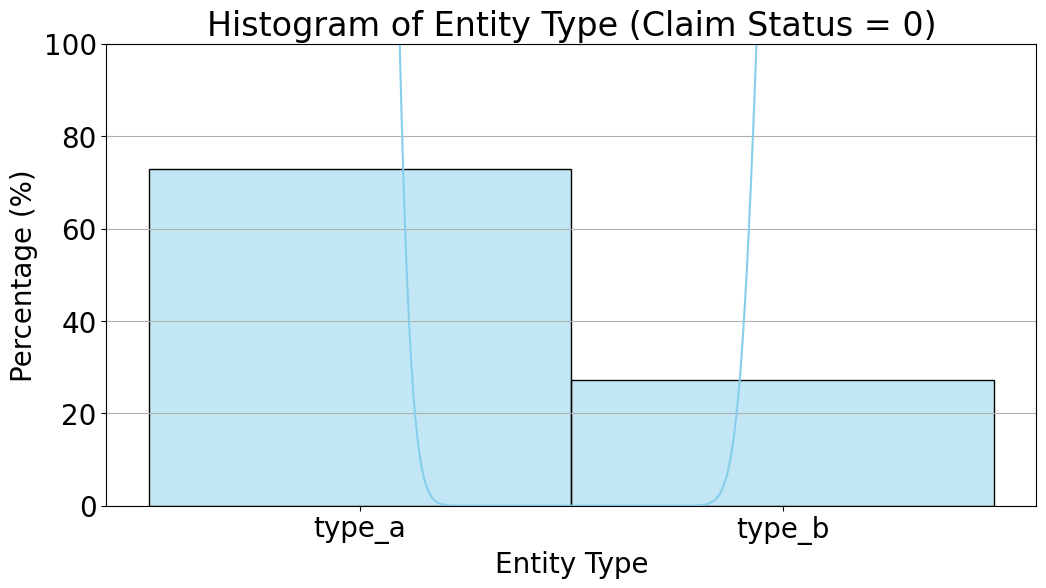

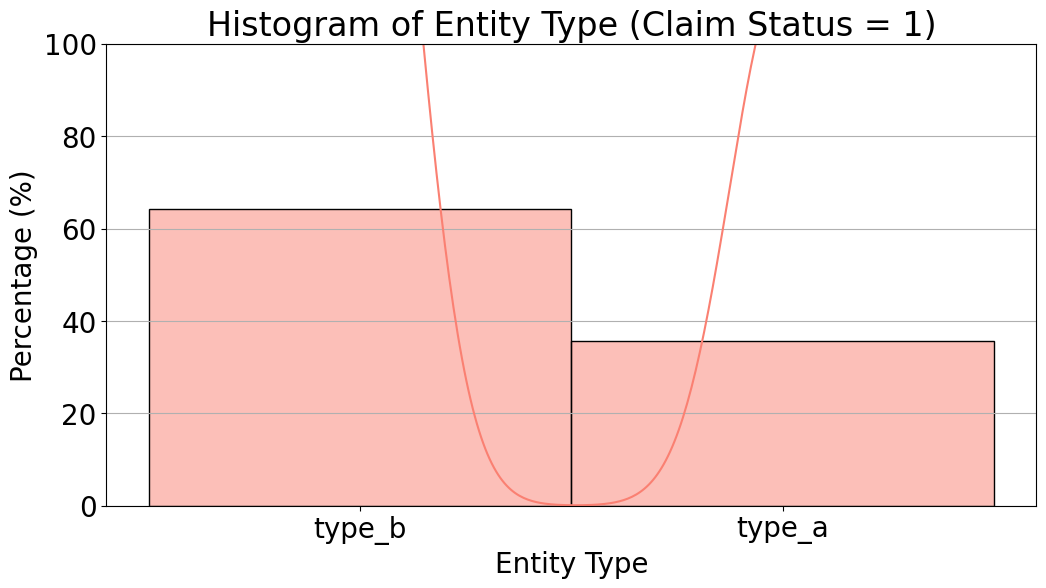

In [21]:
#Distribution of entity type  - 2 separate plots by claim status and 2 separate tables with counts and percentages
entity_counts_claim_0 = df[df['claim_status'] == 0]['entity_type'].value_counts()
entity_percent_claim_0 = df[df['claim_status'] == 0]['entity_type'].value_counts(normalize=True) * 100

entity_counts_claim_1 = df[df['claim_status'] == 1]['entity_type'].value_counts()
entity_percent_claim_1 = df[df['claim_status'] == 1]['entity_type'].value_counts(normalize=True) * 100

# Creating tables
entity_distribution_claim_0 = pd.DataFrame({
    'Count': entity_counts_claim_0,
    'Percentage': entity_percent_claim_0.round(2)
})
print("Distribution of entity_type (Claim Status = 0):")
print(entity_distribution_claim_0)

entity_distribution_claim_1 = pd.DataFrame({
    'Count': entity_counts_claim_1,
    'Percentage': entity_percent_claim_1.round(2)
})
print("Distribution of entity_type (Claim Status = 1):")
print(entity_distribution_claim_1)

# Plotting by share percentage - percentage share on Y plot - scale Y to max 100%
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 0], x='entity_type', bins=30, kde=True, color='skyblue', stat="percent")
plt.title('Histogram of Entity Type (Claim Status = 0)')
plt.xlabel('Entity Type')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)  # Scale Y to max 100%
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 1], x='entity_type', bins=30, kde=True, color='salmon', stat="percent")
plt.title('Histogram of Entity Type (Claim Status = 1)')
plt.xlabel('Entity Type')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)  # Scale Y to max 100%
plt.grid(axis='y')
plt.show()


Distribution of channel (Claim Status = 0):
         Count  Percentage
channel                   
web      54609       98.29
retail     952        1.71
Distribution of channel (Claim Status = 1):
         Count  Percentage
channel                   
web        816       98.08
retail      16        1.92


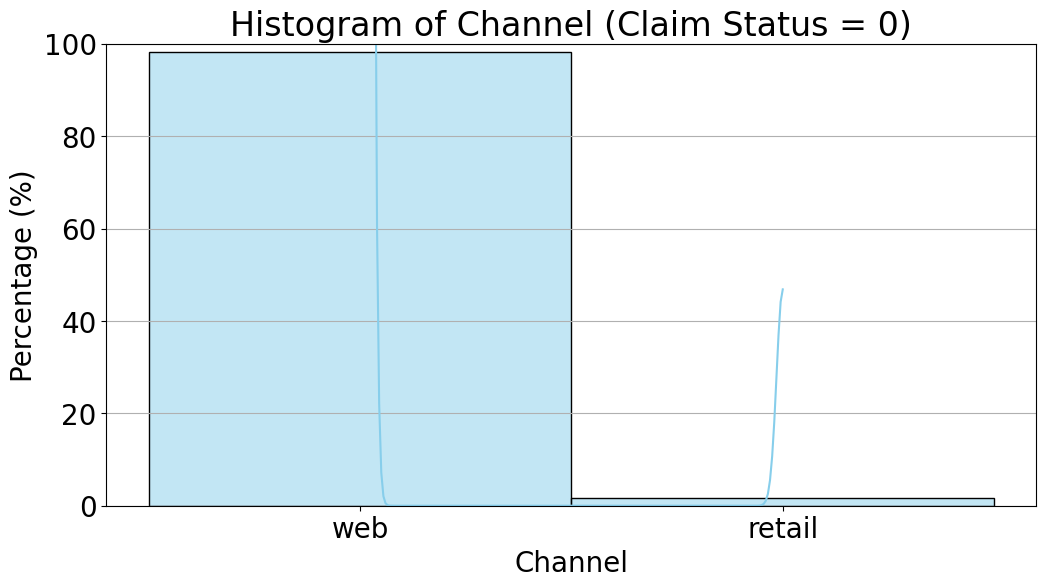

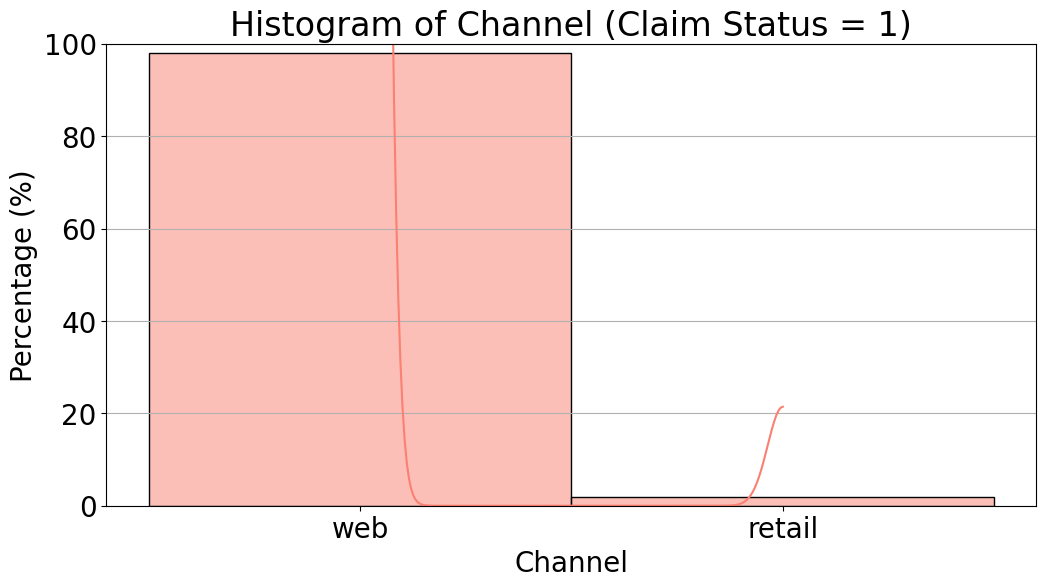

In [22]:
#Distribution of channel  - 2 separate plots by claim status and 2 separate tables with counts and percentages
channel_counts_claim_0 = df[df['claim_status'] == 0]['channel'].value_counts()
channel_percent_claim_0 = df[df['claim_status'] == 0]['channel'].value_counts(normalize=True) * 100

channel_counts_claim_1 = df[df['claim_status'] == 1]['channel'].value_counts()
channel_percent_claim_1 = df[df['claim_status'] == 1]['channel'].value_counts(normalize=True) * 100

# Creating tables
channel_distribution_claim_0 = pd.DataFrame({
    'Count': channel_counts_claim_0,
    'Percentage': channel_percent_claim_0.round(2)
})
print("Distribution of channel (Claim Status = 0):")
print(channel_distribution_claim_0)

channel_distribution_claim_1 = pd.DataFrame({
    'Count': channel_counts_claim_1,
    'Percentage': channel_percent_claim_1.round(2)
})
print("Distribution of channel (Claim Status = 1):")
print(channel_distribution_claim_1)

# Plotting by share percentage - percentage share on Y plot - scale Y to max 100%
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 0], x='channel', bins=30, kde=True, color='skyblue', stat="percent")
plt.title('Histogram of Channel (Claim Status = 0)')
plt.xlabel('Channel')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)  # Scale Y to max 100%
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 1], x='channel', bins=30, kde=True, color='salmon', stat="percent")
plt.title('Histogram of Channel (Claim Status = 1)')
plt.xlabel('Channel')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)  # Scale Y to max 100%
plt.grid(axis='y')
plt.show()


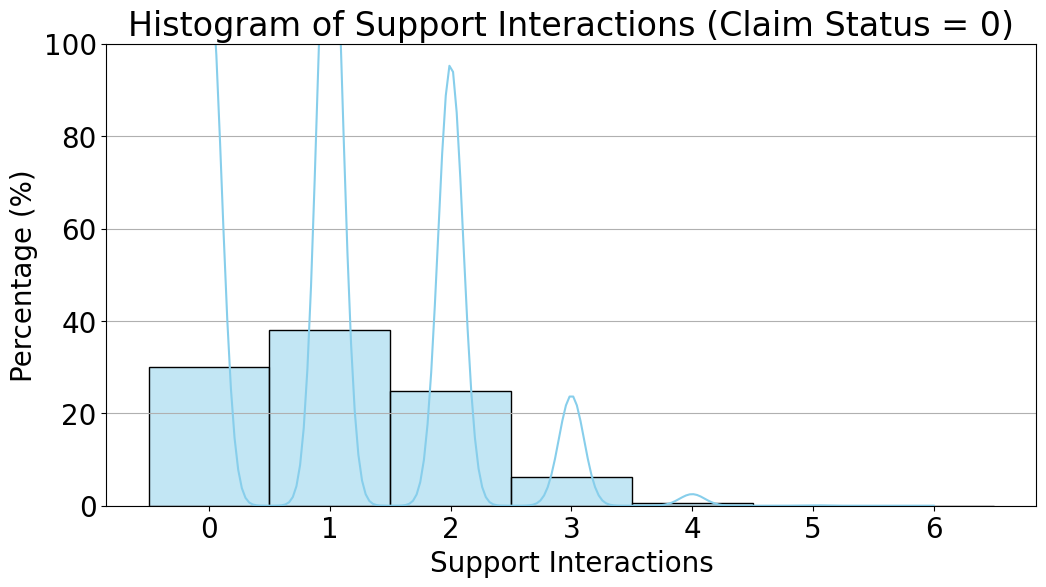

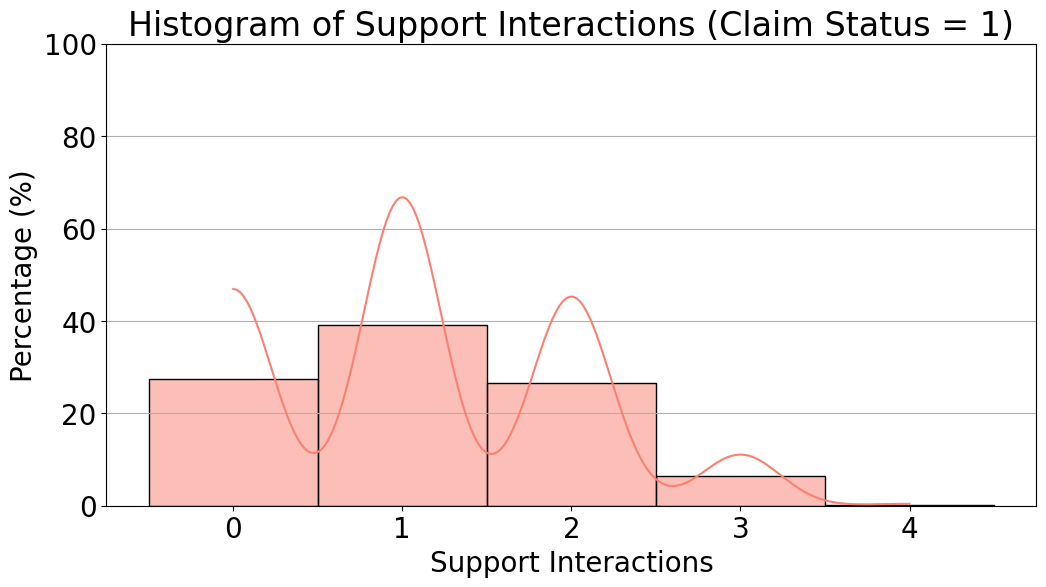

In [23]:
#support_interactions values on histogram - 2 separate plots by claim status - i want to make it a categorical variable using it's values as there are only 7 unique values
df['support_interactions'] = df['support_interactions'].astype('category')
# Plotting by share percentage - percentage share on Y plot - scale Y to max 100%
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 0], x='support_interactions', bins=30, kde=True, color='skyblue', stat="percent")
plt.title('Histogram of Support Interactions (Claim Status = 0)')
plt.xlabel('Support Interactions')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)  # Scale Y to max 100%
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 1], x='support_interactions', bins=30, kde=True, color='salmon', stat="percent")
plt.title('Histogram of Support Interactions (Claim Status = 1)')
plt.xlabel('Support Interactions')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)  # Scale Y to max 100%
plt.grid(axis='y')
plt.show()


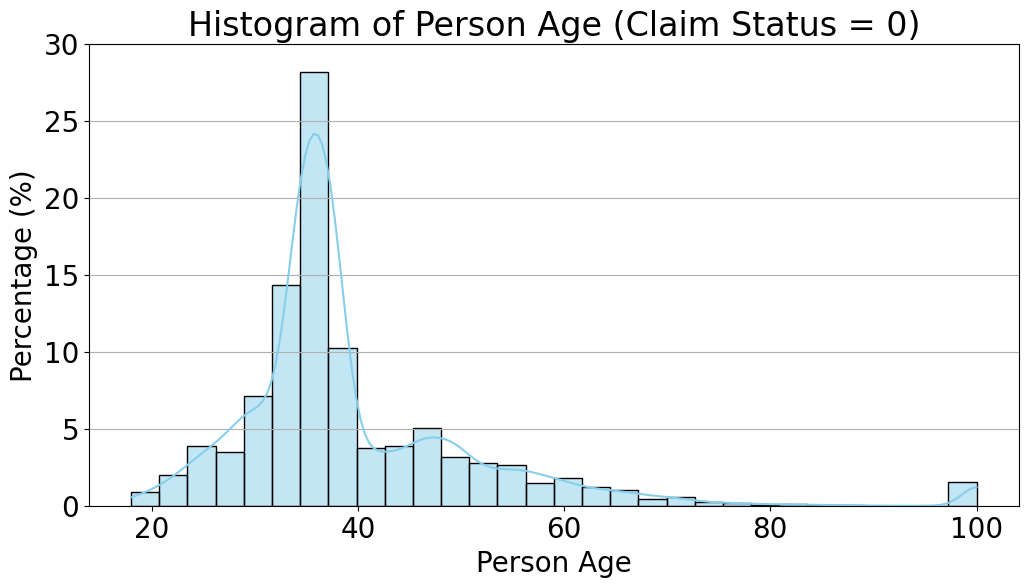

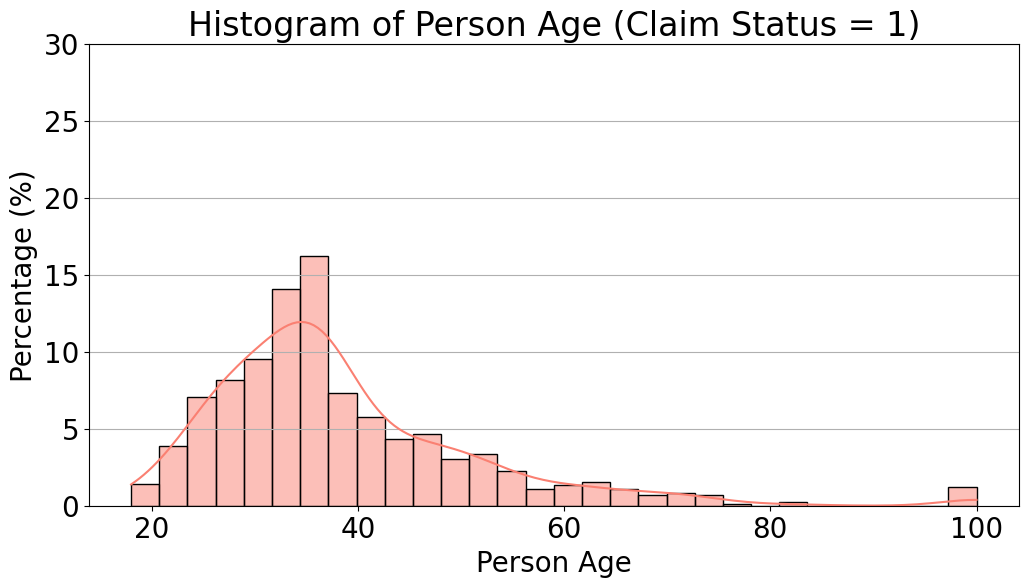

In [24]:
#person_age values on histogram - 2 separate plots by claim status
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 0], x='person_age', bins=30, kde=True, color='skyblue', stat="percent")
plt.title('Histogram of Person Age (Claim Status = 0)')
plt.xlabel('Person Age')
plt.ylabel('Percentage (%)')
plt.ylim(0, 30)  # Scale Y to max 100%
plt.grid(axis='y')
plt.show()
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 1], x='person_age', bins=30, kde=True, color='salmon', stat="percent")
plt.title('Histogram of Person Age (Claim Status = 1)')
plt.xlabel('Person Age')
plt.ylabel('Percentage (%)')
plt.ylim(0, 30)  # Scale Y to max 100%
plt.grid(axis='y')
plt.show()

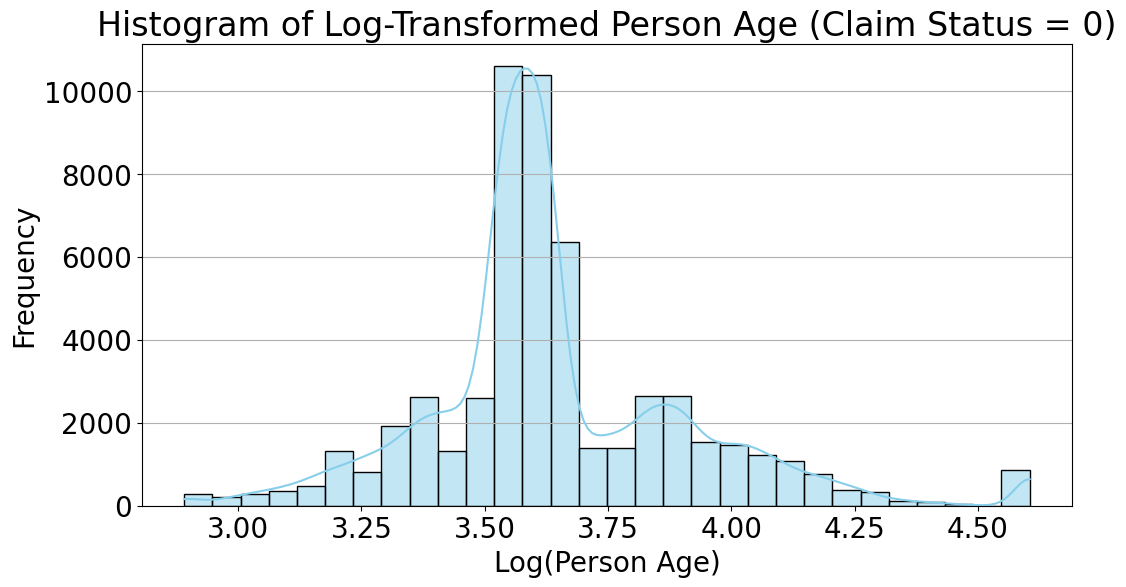

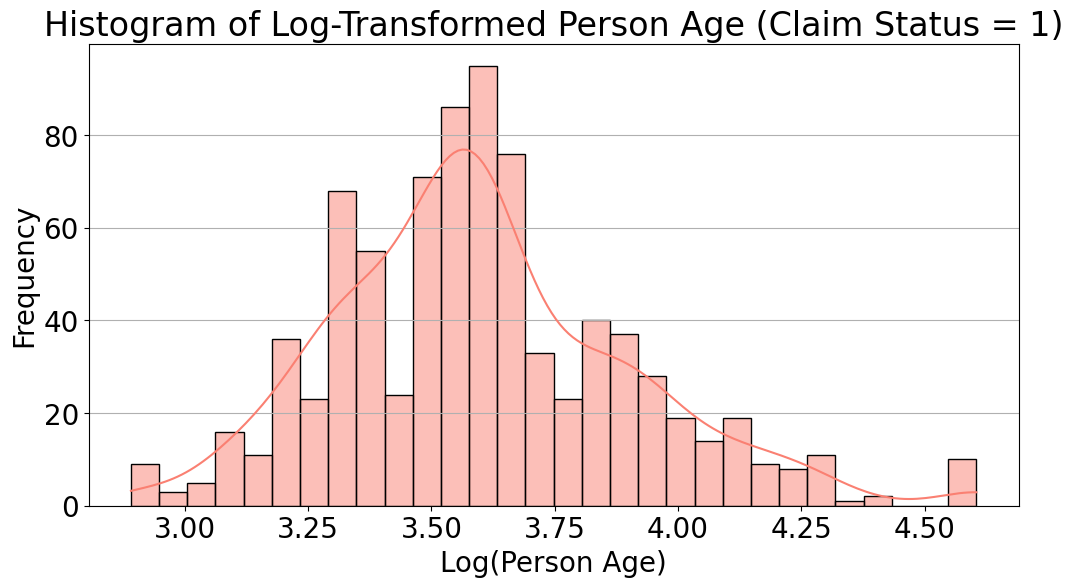

In [25]:
# Logging the age variable
df['log_person_age'] = np.log(df['person_age'])
# Plotting the log-transformed variable - separate plots by claim status
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 0], x='log_person_age', bins=30, kde=True, color='skyblue')
plt.title('Histogram of Log-Transformed Person Age (Claim Status = 0)')
plt.xlabel('Log(Person Age)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 1], x='log_person_age', bins=30, kde=True, color='salmon')
plt.title('Histogram of Log-Transformed Person Age (Claim Status = 1)')
plt.xlabel('Log(Person Age)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()


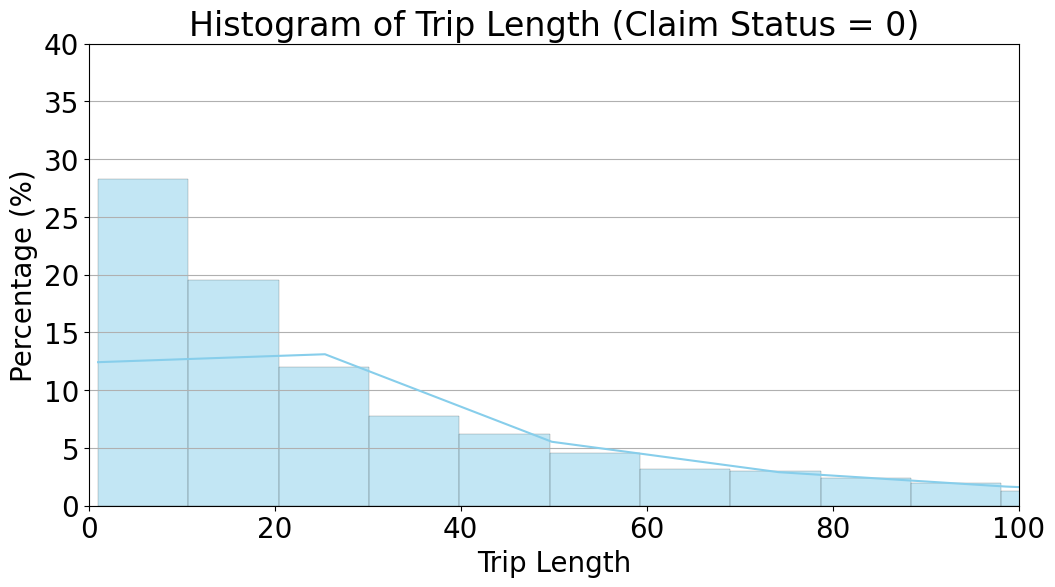

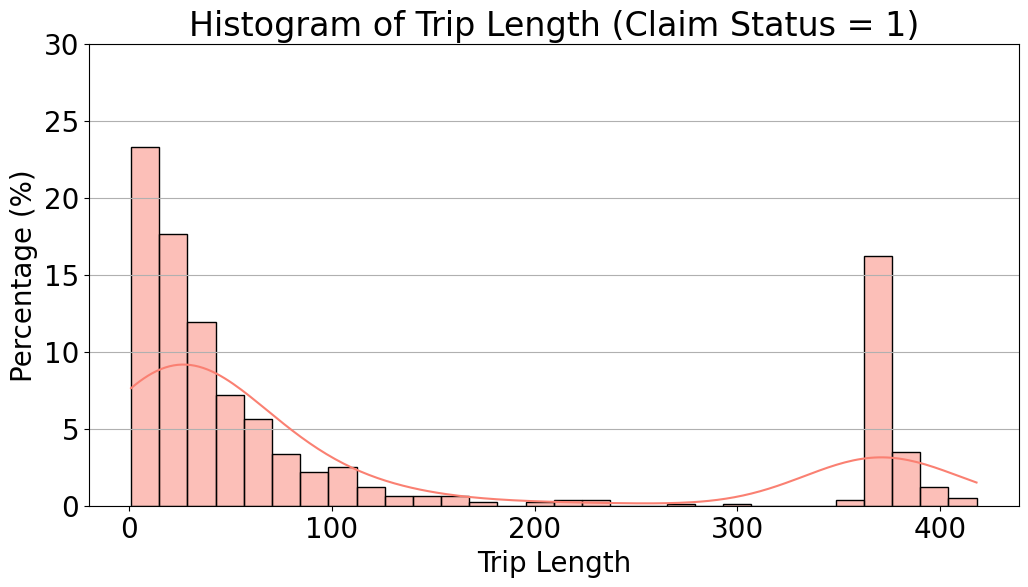

In [26]:
#trip_len values on histogram - 2 separate plots by claim status
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 0], x='trip_length', bins=500, kde=True, color='skyblue', stat="percent")
plt.title('Histogram of Trip Length (Claim Status = 0)')
plt.xlabel('Trip Length')
plt.ylabel('Percentage (%)')
plt.ylim(0, 40)  # Scale Y to max 100%
plt.xlim(0, 100)
plt.grid(axis='y')
plt.show()
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 1], x='trip_length', bins=30, kde=True, color='salmon', stat="percent")
plt.title('Histogram of Trip Length (Claim Status = 1)')
plt.xlabel('Trip Length')
plt.ylabel('Percentage (%)')
plt.ylim(0, 30)  # Scale Y to max 100%
plt.grid(axis='y')
plt.show()

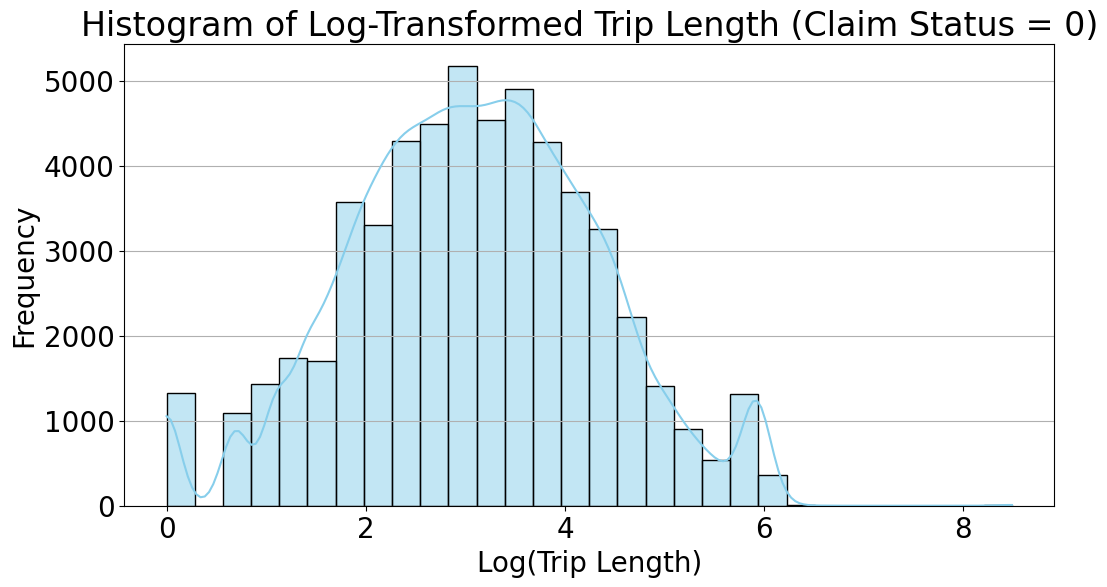

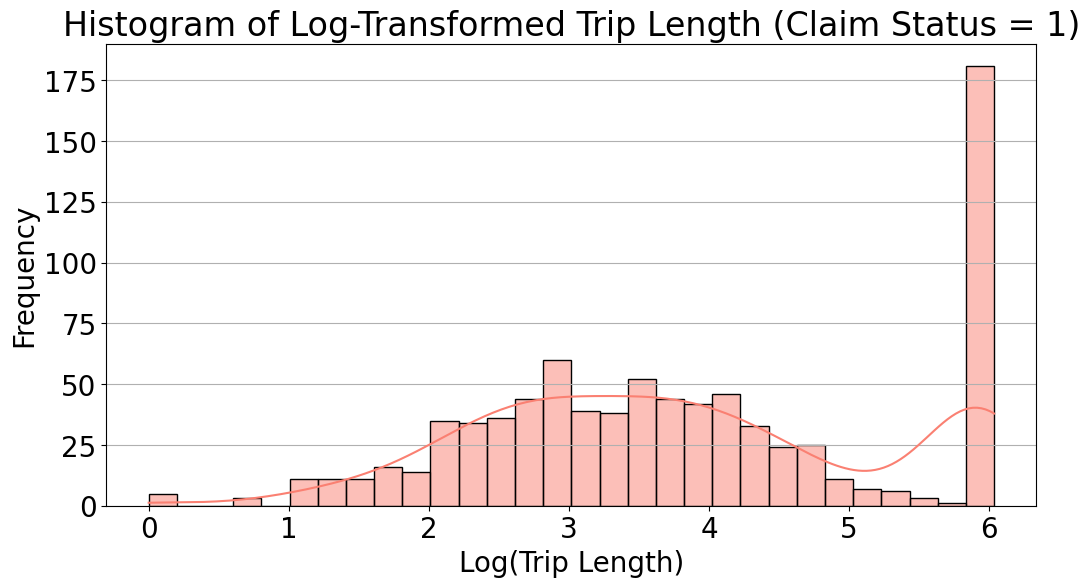

In [27]:
# Logging the trip_length variable
df['log_trip_length'] = np.log(df['trip_length'].replace(0, 0.001))
# Plotting the log-transformed variable - separate plots by claim status
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 0], x='log_trip_length', bins=30, kde=True, color='skyblue')
plt.title('Histogram of Log-Transformed Trip Length (Claim Status = 0)')
plt.xlabel('Log(Trip Length)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 1], x='log_trip_length', bins=30, kde=True, color='salmon')
plt.title('Histogram of Log-Transformed Trip Length (Claim Status = 1)')
plt.xlabel('Log(Trip Length)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

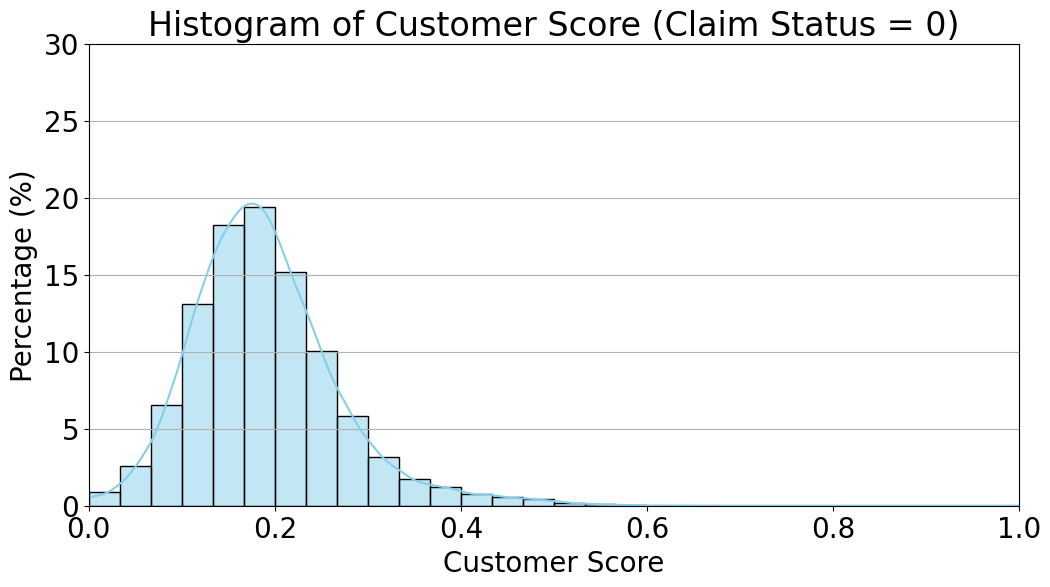

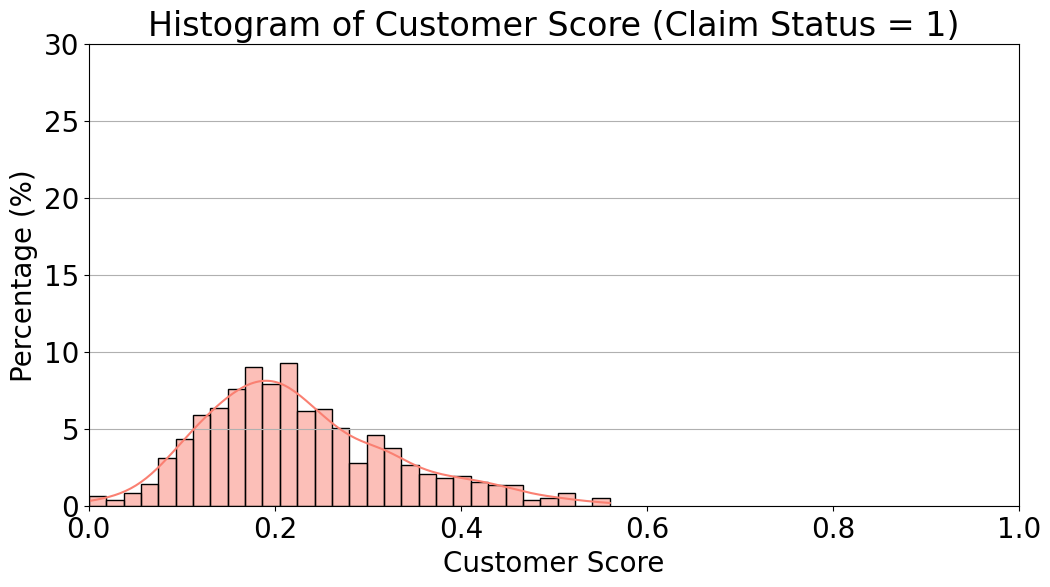

In [28]:
#customer_score values on histogram - 2 separate plots by claim status
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 0], x='customer_score', bins=30, kde=True, color='skyblue', stat="percent")
plt.title('Histogram of Customer Score (Claim Status = 0)')
plt.xlabel('Customer Score')
plt.ylabel('Percentage (%)')
plt.ylim(0, 30)  # Scale Y to max 100%
plt.xlim(0, 1)
plt.grid(axis='y')
plt.show()
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 1], x='customer_score', bins=30, kde=True, color='salmon', stat="percent")
plt.title('Histogram of Customer Score (Claim Status = 1)')
plt.xlabel('Customer Score')
plt.ylabel('Percentage (%)')
plt.ylim(0, 30)  # Scale Y to max 100%
plt.xlim(0, 1)
plt.grid(axis='y')
plt.show()


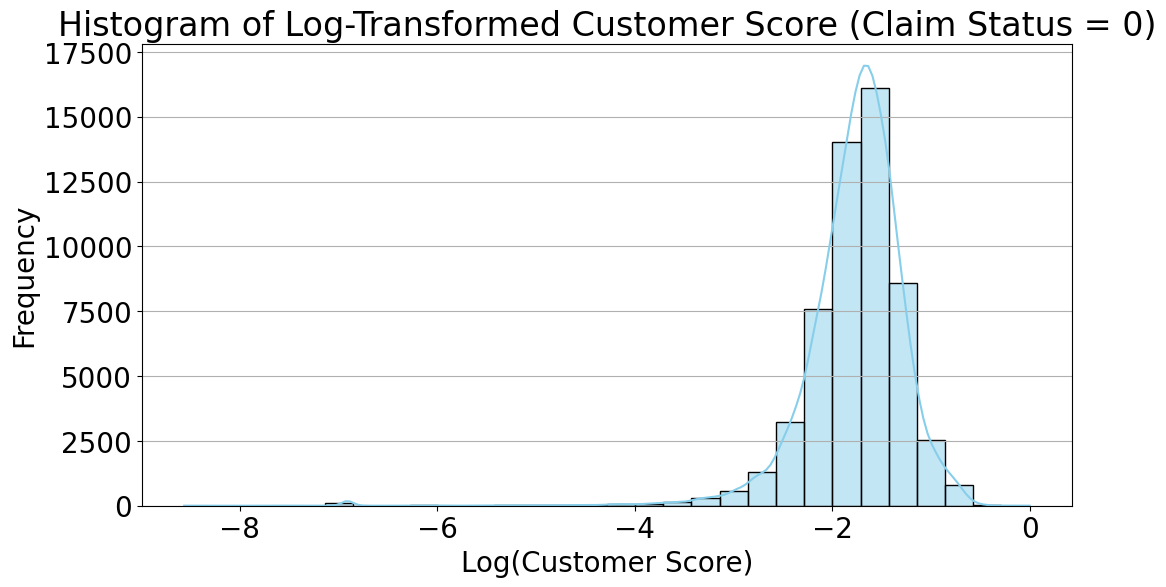

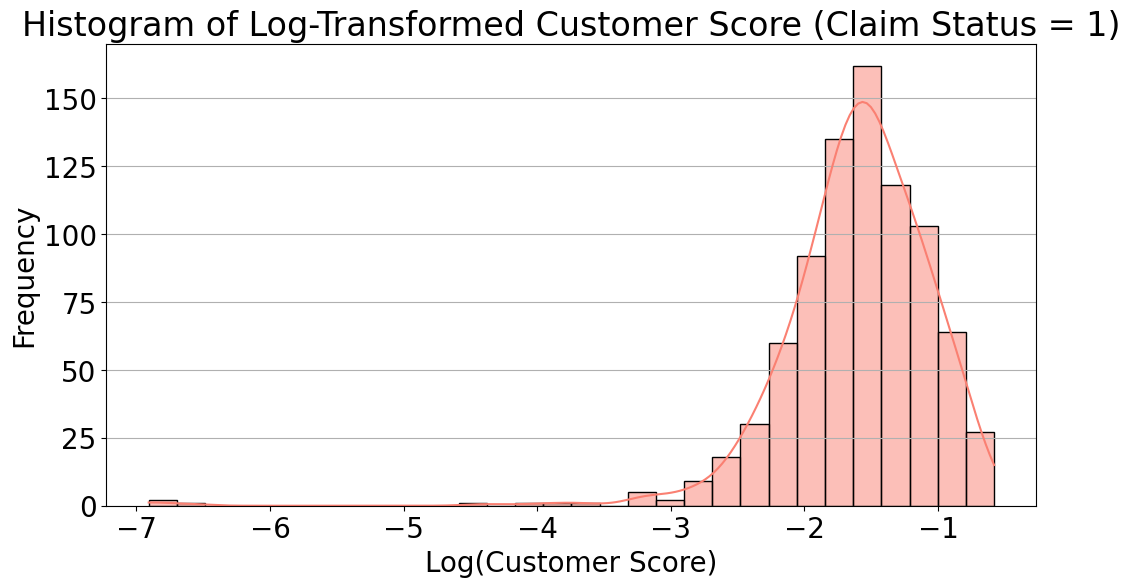

In [29]:
# Logging the customer_score variable
df['log_customer_score'] = np.log(df['customer_score'].replace(0, 0.001))
# Plotting the log-transformed variable - separate plots by claim status
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 0], x='log_customer_score', bins=30, kde=True, color='skyblue')
plt.title('Histogram of Log-Transformed Customer Score (Claim Status = 0)')
plt.xlabel('Log(Customer Score)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['claim_status'] == 1], x='log_customer_score', bins=30, kde=True, color='salmon')
plt.title('Histogram of Log-Transformed Customer Score (Claim Status = 1)')
plt.xlabel('Log(Customer Score)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

Turning to the categorical variables

In [30]:
# check for 0 values in all log variables
log_columns = ['log_revenue', 'log_reward', 'log_person_age', 'log_trip_length', 'log_customer_score']
for col in log_columns:
    print(f"Number of 0 values in {col}: {df[df[col] == 0].shape[0]}") 
# check for negative values in all log variables
for col in log_columns:
    print(f"Number of negative values in {col}: {df[df[col] < 0].shape[0]}")
# check for NaN values in all log variables
for col in log_columns:
    print(f"Number of NaN values in {col}: {df[col].isnull().sum()}")

Number of 0 values in log_revenue: 0
Number of 0 values in log_reward: 0
Number of 0 values in log_person_age: 0
Number of 0 values in log_trip_length: 1334
Number of 0 values in log_customer_score: 1
Number of negative values in log_revenue: 1845
Number of negative values in log_reward: 32003
Number of negative values in log_person_age: 0
Number of negative values in log_trip_length: 0
Number of negative values in log_customer_score: 56392
Number of NaN values in log_revenue: 0
Number of NaN values in log_reward: 0
Number of NaN values in log_person_age: 0
Number of NaN values in log_trip_length: 0
Number of NaN values in log_customer_score: 0


In [31]:
#Code making all continuous variables categorical
#I want to keep only those columns: log revenue, log reward, log trip length, log customer score, log person age, support interactions, gender, entity type, channel, location, agent and of course claim status
continuous_columns = ['log_revenue', 'log_reward', 'log_trip_length', 'log_customer_score', 'log_person_age']
# As support interactions is already categorical, we will not convert it
categorical_columns = ['person_gender', 'entity_type', 'channel', 'location', 'agent_id', 'claim_status', 'support_interactions']
# Create bins for continuous variables
# Liczba binów dla każdej zmiennej (możesz dostosować w razie potrzeby)

n_bins_dict = {
    'log_revenue': 5,
    'log_reward': 5,
    'log_trip_length': 5,
    'log_customer_score': 4,
    'log_person_age': 4
}
# Replace inf/-inf with NaN before binning
for col, n_bins in n_bins_dict.items():
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    # Optionally, drop rows with NaN or fill with a value before binning
    # df = df.dropna(subset=[col])
    # Create a new column with the binned values
    df[f'{col}_cat'] = pd.cut(df[col], bins=n_bins, labels=[f'{i+1}' for i in range(n_bins)], include_lowest=True)

#I want to keep only those columns: log revenue, log reward, log trip length, log customer score, log person age, support interactions, gender, entity type, channel, location, agent and of course claim status
df2 = df[['log_revenue_cat', 'log_reward_cat', 'log_trip_length_cat', 'log_customer_score_cat', 'log_person_age_cat', 'support_interactions', 'person_gender', 'entity_type', 'channel', 'location', 'agent_id', 'claim_status']]

# Change countries from location into regions
def map_to_region(location):
    southeast_asia = ['singapore', 'malaysia', 'thailand', 'indonesia', 'philippines', 'viet nam', 'brunei darussalam', 'cambodia', 'myanmar', 'lao people\'s democratic republic']
    east_asia = ['china', 'hong kong', 'japan', 'korea, republic of', 'taiwan, province of china', 'macao']
    south_asia = ['india', 'nepal']
    oceania = ['australia', 'new zealand']
    north_america = ['united states', 'canada', 'costa rica', 'cayman islands']
    europe = ['united kingdom', 'france', 'germany', 'italy', 'netherlands', 'spain', 'switzerland', 'iceland', 'finland', 'greece', 'norway', 'czech republic']
    middle_east = ['united arab emirates', 'israel', 'turkey']
    africa = ['south africa', 'cameroon', 'senegal']
    south_america = ['argentina']
    central_asia = ['tajikistan', 'armenia']
    
    if location in southeast_asia:
        return 'Southeast Asia'
    elif location in east_asia:
        return 'East Asia'
    elif location in south_asia:
        return 'South Asia'
    elif location in oceania:
        return 'Oceania'
    elif location in north_america:
        return 'North America'
    elif location in europe:
        return 'Europe'
    elif location in middle_east:
        return 'Middle East'
    elif location in africa:
        return 'Africa'
    elif location in south_america:
        return 'South America'
    elif location in central_asia:
        return 'Central Asia'
    else:
        return 'Other'


df2['region'] = df2['location'].apply(map_to_region)
#Drop the original location column
df2.drop(columns=['location'], inplace=True)

df2.head(50)

,log_revenue_cat,log_reward_cat,log_trip_length_cat,log_customer_score_cat,log_person_age_cat,support_interactions,person_gender,entity_type,channel,agent_id,claim_status,region
0,5,1,2,4,3,0,9b2d5b46,type_a,web,agt_0004,0,North America
1,4,4,2,4,2,0,9b2d5b46,type_a,web,agt_0001,0,Europe
2,5,1,3,4,2,1,9b2d5b46,type_a,web,agt_0004,0,Oceania
3,4,1,3,4,2,0,9b2d5b46,type_a,web,agt_0004,0,Southeast Asia
4,4,1,3,3,2,2,9b2d5b46,type_a,web,agt_0004,0,Southeast Asia
5,5,5,3,4,2,1,9b2d5b46,type_a,web,agt_0001,0,Oceania
6,5,5,3,4,1,1,9b2d5b46,type_a,web,agt_0001,0,Other
7,4,1,2,4,2,1,9b2d5b46,type_a,web,agt_0004,0,Southeast Asia
8,4,4,2,3,2,1,f67ab10a,type_b,web,agt_0002,0,Southeast Asia
9,4,4,3,3,2,2,f67ab10a,type_b,web,agt_0005,0,Southeast Asia


In [32]:
#check and remove nans
print(df2.isna().sum())
df2 = df2.dropna()

log_revenue_cat           0
log_reward_cat            0
log_trip_length_cat       0
log_customer_score_cat    0
log_person_age_cat        0
support_interactions      0
person_gender             0
entity_type               0
channel                   0
agent_id                  0
claim_status              0
region                    0
dtype: int64


In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Oddziel X i y
X = df2.drop(columns='claim_status')
y = df2['claim_status']

# Podział na zbiory treningowy i walidacyjny
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Lista modeli
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

# SMOTE + model pipeline
pipelines = {
    name: ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ]) for name, model in models.items()
}


In [35]:
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    score = balanced_accuracy_score(y_val, y_pred)
    print(f"{name} - Balanced Accuracy: {score:.4f}")


ValueError: could not convert string to float: '9b2d5b46'

BUFOR









In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # Oddziel X i y
# X = df2.drop(columns='claim_status')
# y = df2['claim_status']

# # Podział na zbiory treningowy i walidacyjny
# X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import balanced_accuracy_score
# from imblearn.pipeline import Pipeline as ImbPipeline
# from imblearn.over_sampling import SMOTE

# # Lista modeli
# models = {
#     'Logistic Regression': LogisticRegression(max_iter=1000),
#     'SVM': SVC(),
#     'KNN': KNeighborsClassifier()
# }

# # SMOTE + model pipeline
# pipelines = {
#     name: ImbPipeline([
#         ('smote', SMOTE(random_state=42)),
#         ('clf', model)
#     ]) for name, model in models.items()
# }


In [ ]:
# # Adjust it for both numeric and categorical features
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer

# # Define the categorical and numerical columns
# categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
# numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
# # Define the preprocessing for numerical and categorical features
# numerical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])
# # Combine preprocessing steps
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols),
#         ('cat', categorical_transformer, categorical_cols)
#     ]
# )
# # Create pipelines for each model using ImbPipeline to support SMOTE
# for name, model in models.items():
#     pipelines[name] = ImbPipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('smote', SMOTE(random_state=42)),
#         ('clf', model)
#     ])
# # Fit and evaluate each model
# results = {}
# for name, pipeline in pipelines.items():
#     pipeline.fit(X_train, y_train)
#     y_pred = pipeline.predict(X_val)
#     results[name] = balanced_accuracy_score(y_val, y_pred)
# # Print results
# for name, score in results.items():
#     print(f"{name}: {score:.4f}")
# # Save the best model
# best_model_name = max(results, key=results.get)
# best_model = pipelines[best_model_name]
# best_model.fit(X_train, y_train)

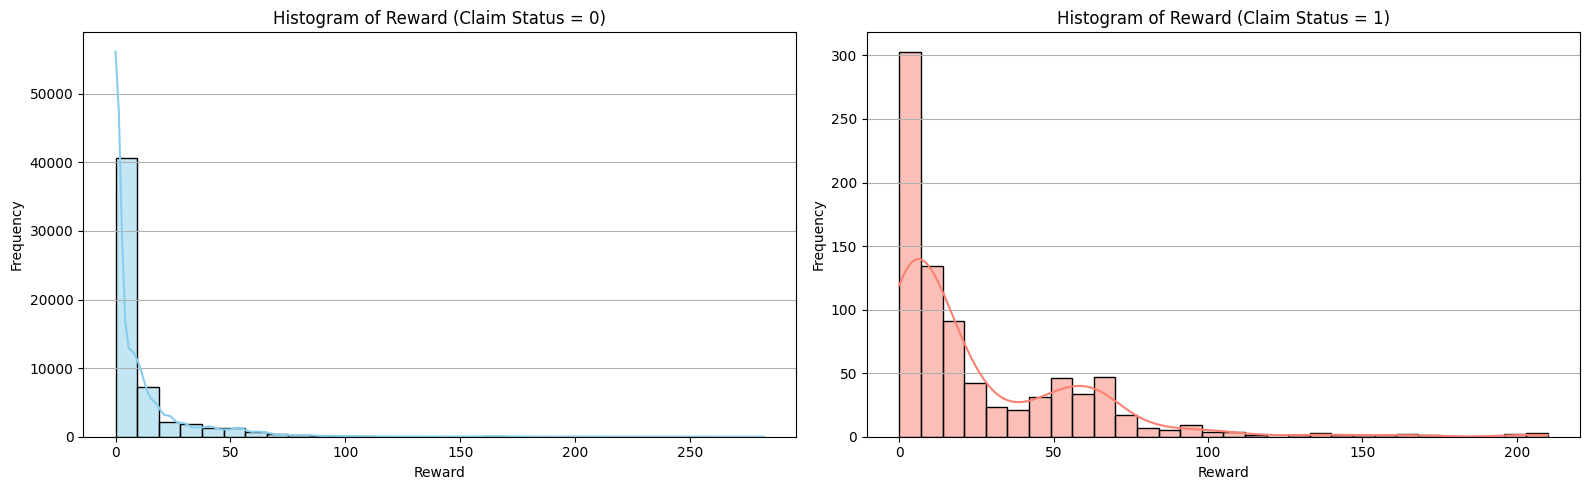

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
raw_input_data_path = r"C:\Users\wojci\Desktop\Machine Learning\MachineLearning1\Insurances\data_input"
preprocessed_output_data_path = r"C:\Users\wojci\Desktop\Machine Learning\MachineLearning1\Insurances\data_output"
df = pd.read_csv(f"{raw_input_data_path}/insurance_train.csv")
# Utworzenie figure i dwóch subplots obok siebie z oddzielnymi osiami Y
fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # bez sharey=True

# Histogram dla claim_status = 0
sns.histplot(data=df[df['claim_status'] == 0], x='reward', bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Histogram of Reward (Claim Status = 0)')
axes[0].set_xlabel('Reward')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y')

# Histogram dla claim_status = 1
sns.histplot(data=df[df['claim_status'] == 1], x='reward', bins=30, kde=True, color='salmon', ax=axes[1])
axes[1].set_title('Histogram of Reward (Claim Status = 1)')
axes[1].set_xlabel('Reward')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(24, 16))
sns.heatmap(corr_columns.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
num_cols = ['claim status', 'reward', 'revenue', 'trip_length', 'person_age', 'customer_score', 'support_interactions']

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()


In [ ]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x='claim_status', y=col)
    plt.title(f'{col} by claim_status')
    plt.show()


In [ ]:
cat_cols = ['channel', 'entity_type', 'product_id', 'location', 'person_gender']

for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, hue='claim_status')
    plt.xticks(rotation=45)
    plt.title(f'{col} vs claim_status')
    plt.show()


In [ ]:
print(df['agent_id'].nunique())
print(df['entity_a'].nunique())


In [ ]:
def plot_pie_charts(df, categorical_features):
    plt.figure(figsize=(40, 8))  # Zwiększony rozmiar
    plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Więcej przestrzeni między wykresami
    
    for i, feature in enumerate(categorical_features, 1):
        ax = plt.subplot(1, 4, i)
        data = df[feature].value_counts(normalize=True).head(15)  # Ogranicz do top 15

        # Wykres kołowy z etykietami w legendzie
        wedges, texts, autotexts = ax.pie(
            data,
            labels=None,  # Usuwamy etykiety na wykresie
            autopct=lambda pct: f'{pct:.1f}%' if pct > 1 else '',  # Tylko powyżej 5%
            startangle=90,
            colors=sns.color_palette("pastel"),
            wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
            textprops={'fontsize': 10, 'rotation': 45},  # Obracamy procenty
            pctdistance=0.75,
            radius=1.2  # Zwiększamy rozmiar koła
        )
        
        # Legenda z prawej strony
        ax.legend(
            wedges, 
            data.index,
            title=f'Kategorie: {feature}',
            loc='center left',
            bbox_to_anchor=(1, 0.5),
            fontsize=9
        )
        
        # Tytuł
        ax.set_title(f'Rozkład dla: {feature}', fontsize=14, pad=20)

    plt.show()

categorical_features = ['location', 'product_id', 'channel', 'entity_type']
plot_pie_charts(df, categorical_features)

In [ ]:
def plot_pie_charts_by_claim_status(df, categorical_features):
    # Podziel dane na dwa podzbiory
    df_0 = df[df['claim_status'] == 0]
    df_1 = df[df['claim_status'] == 1]
    
    # Stwórz wykresy dla claim_status = 0
    print("\n" + "="*50 + "\nRozkład dla przypadków gdzie claim_status = 0\n" + "="*50)
    plot_pie_charts(df_0, categorical_features)
    
    # Stwórz wykresy dla claim_status = 1
    print("\n" + "="*50 + "\nRozkład dla przypadków gdzie claim_status = 1\n" + "="*50)
    plot_pie_charts(df_1, categorical_features)

# Lista cech kategorycznych do wizualizacji
categorical_features = [ 'person_gender', 'entity_type', 'channel', 'support_interactions', 'agent_id', 'entity_a', 'person_age', 'location', 'product_id', 'trip_length']

# Wywołanie funkcji
plot_pie_charts_by_claim_status(df, categorical_features)

def plot_pie_charts(df, categorical_features):
    n_features = len(categorical_features)
    cols = 4
    rows = (n_features + cols - 1) // cols  # Zaokrąglenie w górę

    plt.figure(figsize=(5 * cols, 5 * rows))

    for i, feature in enumerate(categorical_features, 1):
        ax = plt.subplot(rows, cols, i)
        data = df[feature].value_counts(normalize=True).head(15)

        if len(data) == 0:
            print(f"Brak danych dla cechy {feature}")
            continue

        wedges, texts, autotexts = ax.pie(
            data,
            labels=None,
            autopct=lambda pct: f'{pct:.1f}%' if pct > 5 else '',
            startangle=90,
            colors=sns.color_palette("pastel"),
            wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
            textprops={'fontsize': 10},
            pctdistance=0.8
        )

        ax.legend(
            wedges,
            [f"{label} ({pct:.1f}%)" for label, pct in zip(data.index, data * 100)],
            title=f'{feature}',
            loc='center left',
            bbox_to_anchor=(1, 0.5),
            fontsize=9
        )

        ax.set_title(f'Rozkład: {feature}', fontsize=12)

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_claim_rate_bars(df, categorical_features, top_n=10):
    for feature in categorical_features:
        plt.figure(figsize=(12, 6))
        claim_rates = df.groupby(feature)['claim_status'].mean().sort_values(ascending=False).head(top_n)
        sns.barplot(x=claim_rates.values, y=claim_rates.index, palette="Reds_r")
        plt.title(f'Procent roszczeń (claim=1) wg {feature}')
        plt.xlabel('Claim Rate (%)')
        plt.ylabel(feature)
        plt.xlim(0, 1)
        plt.show()

plot_claim_rate_bars(df, categorical_features)


In [ ]:
import matplotlib.pyplot as plt

# Przykład dla zmiennej 'person_age'
fig, ax1 = plt.subplots(figsize=(10, 6))

# Dla claim=0
ax1.hist(df[df['claim_status'] == 0]['person_age'], bins=30, color='blue', alpha=0.6, label='No Claim (0)')
ax1.set_xlabel('Age')
ax1.set_ylabel('Count (Claim=0)', color='blue')

# Dla claim=1 (druga oś)
ax2 = ax1.twinx()
ax2.hist(df[df['claim_status'] == 1]['person_age'], bins=30, color='red', alpha=0.6, label='Claim (1)')
ax2.set_ylabel('Count (Claim=1)', color='red')

plt.title('Age Distribution by Claim Status')
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix[['claim_status']].sort_values(by='claim_status', ascending=False), 
            annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Korelacje z Claim Status')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='claim_status', y='person_age', 
               palette={0: "blue", 1: "red"}, split=True)
plt.title('Rozkład wieku wg Claim Status')
plt.xlabel('Claim Status')
plt.ylabel('Wiek')
plt.xticks([0, 1], ['No Claim (0)', 'Claim (1)'])
plt.show()

In [ ]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='product_id', y='revenue', hue='claim_status',
            palette={0: "blue", 1: "red"}, showfliers=False)
plt.title('Revenue wg Product i Claim Status')
plt.xticks(rotation=45)
plt.legend(title='Claim Status')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='trip_length', hue='claim_status', 
             element="step", stat="density", common_norm=False,
             palette={0: "blue", 1: "red"})
plt.title('Rozkład długości podróży wg Claim Status')
plt.xlabel('Trip Length')
plt.ylabel('Gęstość')
plt.show()

In [ ]:
cross_tab = pd.crosstab(df['entity_type'], df['channel'], 
                        normalize='index', values=df['claim_status'], 
                        aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt=".2%", cmap="YlGnBu")
plt.title('Claim Rate wg Entity Type i Channel')
plt.xlabel('Channel')
plt.ylabel('Entity Type')
plt.show()

In [ ]:
g = sns.FacetGrid(df, col='claim_status', height=6, aspect=1.2)
g.map(sns.scatterplot, 'person_age', 'reward', alpha=0.6)
g.set_axis_labels("Wiek", "Reward")
g.set_titles("Claim Status: {col_name}")
plt.show()

In [ ]:
# Przykład dla zmiennej 'product_id'
import seaborn as sns

# Grupowanie i normalizacja
product_claim = df.groupby(['product_id', 'claim_status']).size().unstack().fillna(0)
product_claim['total'] = product_claim.sum(axis=1)
product_claim['claim_0_pct'] = product_claim[0] / product_claim['total']
product_claim['claim_1_pct'] = product_claim[1] / product_claim['total']

# Wykres
plt.figure(figsize=(12, 6))
sns.barplot(x=product_claim.index, y=product_claim['claim_0_pct'], color='blue', label='No Claim (0)')
sns.barplot(x=product_claim.index, y=product_claim['claim_1_pct'], color='red', label='Claim (1)', bottom=product_claim['claim_0_pct'])
plt.xticks(rotation=90)
plt.title('Claim Rate by Product (Normalized)')
plt.legend()
plt.show()

In [ ]:
# Przykład dla zmiennej 'revenue'
g = sns.FacetGrid(df, col='claim_status', height=5, aspect=1.2)
g.map(sns.histplot, 'revenue', kde=True)
g.set_titles('Claim Status: {col_name}')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_numeric_feature(df, feature):
    plt.figure(figsize=(12, 6))
    
    # Wykres gęstości (KDE) z podziałem na klasy
    sns.kdeplot(data=df, x=feature, hue="claim_status", 
                palette={0: "blue", 1: "red"}, 
                common_norm=False, fill=True, alpha=0.4)
    
    plt.title(f'Rozkład {feature} wg Claim Status')
    plt.xlabel(feature)
    plt.ylabel('Gęstość')
    plt.legend(title='Claim Status', labels=['No Claim (0)', 'Claim (1)'])
    plt.show()
    
def plot_categorical_feature(df, feature, top_n=20):
    plt.figure(figsize=(12, 6))
    
    # Ogranicz do top N kategorii (dla czytelności)
    top_categories = df[feature].value_counts().nlargest(top_n).index
    df_filtered = df[df[feature].isin(top_categories)]
    
    # Znormalizowany wykres słupkowy
    sns.histplot(data=df_filtered, x=feature, hue="claim_status", 
                 stat="percent", common_norm=False, 
                 palette={0: "blue", 1: "red"}, 
                 multiple="dodge", shrink=0.8)
    
    plt.title(f'Procentowy rozkład {feature} wg Claim Status')
    plt.xlabel(feature)
    plt.ylabel('Procent obserwacji')
    plt.xticks(rotation=45)
    plt.legend(title='Claim Status', labels=['No Claim (0)', 'Claim (1)'])
    plt.show()
    
for column in df.columns:
    if column == "claim_status":
        continue  # Pomijamy zmienną celu
    if df[column].dtype in ["int64", "float64"]:
        plot_numeric_feature(df, column)
    else:
        plot_categorical_feature(df, column, top_n=20)

In [ ]:
# Class distribution
sns.countplot(x="claim_status", data=df)
plt.title("Claim Status Distribution")
plt.show()

# Age distribution
sns.histplot(df["person_age"], kde=True)
plt.title("Age Distribution")
plt.show()

# Product vs. Claims
product_claims = df.groupby("product_id")["claim_status"].mean().sort_values(ascending=False)
product_claims.plot(kind="bar")
plt.title("Claim Rate by Product")
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x='claim_status', data=df)
plt.title('Rozkład zmiennej docelowej claim_status')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}\n({p.get_height()/len(df)*100:.1f}%)', 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

In [ ]:
# Krok 5: Analiza zmiennych numerycznych
num_cols = ['reward', 'support_interactions', 'customer_score', 'person_age', 'revenue', 'trip_length']

# Statystyki opisowe
print("\nStatystyki opisowe zmiennych numerycznych:")
print(df[num_cols].describe())

# Wykresy dystrybucji
plt.figure(figsize=(15,10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2,3,i)
    sns.histplot(data=df, x=col, kde=True, hue='claim_status', multiple='stack')
    plt.title(f'Rozkład {col}')
plt.tight_layout()
plt.show()

# Wykresy pudełkowe
plt.figure(figsize=(15,6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1,len(num_cols),i)
    sns.boxplot(y=col, data=df)
    plt.title(f'Boxplot {col}')
plt.tight_layout()
plt.show()

In [ ]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: display basic info
print(df.info())

# Set style
sns.set(style="whitegrid")

# Define numeric columns
numeric_cols = ['reward', 'revenue', 'customer_score', 'person_age', 'trip_length', 'support_interactions']

# Plot distributions of numeric features by claim_status
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.histplot(data=df, x=col, hue='claim_status', kde=True, ax=axes[i], bins=30, palette='Set1')
    axes[i].set_title(f'Distribution of {col} by claim_status')
plt.tight_layout()
plt.show()


In [ ]:
# Select categorical columns
categorical_cols = ['person_gender', 'entity_type', 'channel', 'agent_id', 'entity_a', 'location', 'product_id']

# Separate columns by cardinality
high_cardinality = ['agent_id', 'entity_a', 'location']
low_cardinality = [col for col in categorical_cols if col not in high_cardinality]

# Plot low-cardinality categorical features
fig, axes = plt.subplots(nrows=1, ncols=len(low_cardinality), figsize=(18, 5))
for i, col in enumerate(low_cardinality):
    sns.countplot(data=df, x=col, hue='claim_status', ax=axes[i], palette='Set2')
    axes[i].set_title(f'{col} by claim_status')
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# For high-cardinality: example - show top 10 agents by claim approval rate
claim_rate_df = df.groupby('agent_id')['claim_status'].mean().sort_values(ascending=False).head(10).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=claim_rate_df, x='agent_id', y='claim_status', palette='mako')
plt.title('Top 10 Agents by Claim Approval Rate')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Sprawdzenie korelacji między zmiennymi liczbowymi
numeric_cols = ['reward', 'revenue', 'customer_score', 'person_age', 'trip_length', 'support_interactions']

# Macierz korelacji (wraz z targetem)
corr_matrix = df[numeric_cols + ['claim_status']].corr()

# Wizualizacja jako heatmapa
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix (Numeric Features + Target)')
plt.show()


In [ ]:
# 1. Scatterploty dwóch cech liczbowych z kolorem wg claim_status
sns.pairplot(df, vars=['revenue', 'trip_length', 'reward'], hue='claim_status', corner=True, palette='Set2')
plt.suptitle('Scatterplots of Selected Features Colored by Claim Status', y=1.02)
plt.show()

# 2. Violin plot: trip length vs claim_status
plt.figure(figsize=(8, 6))
sns.violinplot(x='claim_status', y='trip_length', data=df, palette='Set2')
plt.title('Trip Length by Claim Status')
plt.show()

# 3. Bin revenue and trip_length and analyze claim rate in each bin
df['revenue_bin'] = pd.cut(df['revenue'], bins=10)
df['trip_length_bin'] = pd.cut(df['trip_length'], bins=10)

rev_bin_rate = df.groupby('revenue_bin')['claim_status'].mean().reset_index()
trip_bin_rate = df.groupby('trip_length_bin')['claim_status'].mean().reset_index()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=rev_bin_rate, x='revenue_bin', y='claim_status', ax=axes[0], palette='viridis')
axes[0].set_title('Claim Rate by Revenue Bin')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(data=trip_bin_rate, x='trip_length_bin', y='claim_status', ax=axes[1], palette='magma')
axes[1].set_title('Claim Rate by Trip Length Bin')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## FEATURE ENGINEERING

In [ ]:
KOD poniżej robi 0,78

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    StandardScaler, PowerTransformer, OneHotEncoder,
    FunctionTransformer, QuantileTransformer
)
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

# # 1. Drop unnecessary columns and separate target
# drop_cols = ['agent_id', 'entity_a']
# df_clean = df.drop(columns=drop_cols)

X = df2.drop(columns=['claim_status'])
y = df2['claim_status']

# 2. Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Column selectors
numeric_features = make_column_selector(dtype_include=np.number)
categorical_features_low = ['person_gender', 'entity_type', 'channel']
categorical_features_high = ['agent_id', 'entity_a', 'location', 'product_id']

# 4. Outlier clipping transformer
def outlier_clipping(X, lower=0.01, upper=0.99):
    return np.clip(
        X,
        np.nanquantile(X, lower, axis=0),
        np.nanquantile(X, upper, axis=0)
    )

# 5a. Numeric sub-pipelines
numeric_clip_pipeline = Pipeline([
    ('clip', FunctionTransformer(outlier_clipping)),
    ('impute', SimpleImputer(strategy='median', add_indicator=True)),
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scale', StandardScaler())
])

numeric_log_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
    ('impute', SimpleImputer(strategy='median')),
    ('quantile', QuantileTransformer(output_distribution='uniform')),
    ('scale', StandardScaler())
])

# 5b. Low cardinality categoricals
categorical_low_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 5c. High cardinality categoricals
categorical_high_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('target_enc', TargetEncoder())
])

# 6. Combine preprocessor
preprocessor = ColumnTransformer([
    ('num_clip', numeric_clip_pipeline, numeric_features),
    ('cat_low', categorical_low_pipeline, categorical_features_low),
    ('cat_high', categorical_high_pipeline, categorical_features_high)
])

# 7. Full pipeline
full_pipeline = ImbPipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),
    # Możesz zmieniać pomiędzy PCA i SelectKBest – w zależności od potrzeb
    # ('pca', PCA(n_components=30)),
    ('feature_selection', SelectKBest(mutual_info_classif, k=30)),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        class_weight='balanced',
        random_state=42
    ))
])

# 8. Fit & evaluate
full_pipeline.fit(X_train, y_train)
val_score = full_pipeline.score(X_val, y_val)
print(f"Validation Accuracy: {val_score:.4f}")


ValueError: A given column is not a column of the dataframe

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import (
    StandardScaler, PowerTransformer, OneHotEncoder,
    FunctionTransformer, QuantileTransformer
)
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score
from category_encoders import TargetEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


# Definicja celu i cech
X = df2.drop(columns=['claim_status'])
y = df2['claim_status']

# Split train/val stratified
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Funkcja outlier clipping
def outlier_clipping(X, lower=0.01, upper=0.99):
    return np.clip(
        X,
        np.nanquantile(X, lower, axis=0),
        np.nanquantile(X, upper, axis=0)
    )

# Wykrywanie kolumn kategorycznych i ich kardynalności
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
low_card_threshold = 20
categorical_low = [col for col in categorical_cols if X_train[col].nunique() <= low_card_threshold]
categorical_high = [col for col in categorical_cols if X_train[col].nunique() > low_card_threshold]

# Numeryczne kolumny
numeric_features = make_column_selector(dtype_include=np.number)(X_train)

# Pipelines

numeric_pipeline = Pipeline([
    ('clip', FunctionTransformer(outlier_clipping)),
    ('impute', IterativeImputer(random_state=42)),
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scale', StandardScaler())
])

numeric_log_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
    ('impute', IterativeImputer(random_state=42)),
    ('quantile', QuantileTransformer(output_distribution='uniform')),
    ('scale', StandardScaler())
])

categorical_low_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

categorical_high_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('target_enc', TargetEncoder())
])

# Łączenie preprocesora
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat_low', categorical_low_pipeline, categorical_low),
    ('cat_high', categorical_high_pipeline, categorical_high)
])

# Definicja pipeline'u z oversamplingiem i selekcją cech
full_pipeline = ImbPipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),
    ('feature_selection', SelectKBest(mutual_info_classif, k=30)),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Grid Search - parametry do strojenia
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'feature_selection__k': [20, 30, 40]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    full_pipeline,
    param_grid,
    scoring='balanced_accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Fit
grid_search.fit(X_train, y_train)

# Wyniki
print(f"✅ Best params: {grid_search.best_params_}")

# Ewaluacja na walidacji
y_pred = grid_search.predict(X_val)
bal_acc = balanced_accuracy_score(y_val, y_pred)
print(f"🎯 Balanced Accuracy on validation: {bal_acc:.4f}")

print("📊 Classification Report:")
print(classification_report(y_val, y_pred, digits=4))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
✅ Best params: {'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'feature_selection__k': 20}
🎯 Balanced Accuracy on validation: 0.7247
📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9929    0.8650    0.9245     11113
           1     0.0607    0.5843    0.1100       166

    accuracy                         0.8609     11279
   macro avg     0.5268    0.7247    0.5173     11279
weighted avg     0.9792    0.8609    0.9126     11279



In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import (
    StandardScaler, PowerTransformer, OneHotEncoder,
    FunctionTransformer, QuantileTransformer
)
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score
from category_encoders import LeaveOneOutEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import time
import warnings
warnings.filterwarnings('ignore')

# ------------------- #
# PREPROCESSING BLOCK #
# ------------------- #

# Definicja celu i cech
X = df2.drop(columns=['claim_status'])
y = df2['claim_status']

# Split train/val stratified
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# Funkcja outlier clipping
def outlier_clipping(X, lower=0.01, upper=0.99):
    return np.clip(
        X,
        np.nanquantile(X, lower, axis=0),
        np.nanquantile(X, upper, axis=0)
    )

# Wykrywanie kolumn kategorycznych
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
low_card_threshold = 20
categorical_low = [col for col in categorical_cols if X_train[col].nunique() <= low_card_threshold]
categorical_high = [col for col in categorical_cols if X_train[col].nunique() > low_card_threshold]

# Numeryczne kolumny
numeric_features = make_column_selector(dtype_include=np.number)(X_train)

# Pipelines
numeric_pipeline = Pipeline([
    ('clip', FunctionTransformer(outlier_clipping)),
    ('impute', IterativeImputer(random_state=42)),
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scale', StandardScaler())
])

categorical_low_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

categorical_high_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encoder', LeaveOneOutEncoder(sigma=0.1))  # Bezpieczniejszy encoder
])

# Łączony preprocesor
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat_low', categorical_low_pipeline, categorical_low),
    ('cat_high', categorical_high_pipeline, categorical_high)
])

# ------------------ #
# MODELING BLOCK     #
# ------------------ #

# Konfiguracja wag próbek
def custom_sample_weights(y):
    return np.where(y == 1, 15, 1)  # 15:1 dla klasy mniejszościowej

# Dynamiczny balans SMOTE
def auto_smote_ratio(y):
    class_counts = np.bincount(y)
    return {1: int(class_counts[0] * 0.3)}  # 30% stosunek do klasy większościowej

# Modele z parametrami
models_config = {
    'KNN': {
        'pipeline': ImbPipeline([
            ('preprocessing', preprocessor),
            ('smote', SMOTE(sampling_strategy=auto_smote_ratio, random_state=42)),
            ('post_scale', StandardScaler()),  # Dodatkowe skalowanie
            ('feature_selection', SelectKBest(mutual_info_classif)),
            ('classifier', KNeighborsClassifier())
        ]),
        'params': {
            'feature_selection__k': [60, 80],
            'classifier__n_neighbors': [15, 25, 35],
            'classifier__weights': ['distance'],
            'classifier__metric': ['cosine', 'manhattan']
        }
    },
    'HistGradientBoosting': {
        'pipeline': ImbPipeline([
            ('preprocessing', preprocessor),
            ('smote', SMOTE(sampling_strategy=auto_smote_ratio, random_state=42)),
            ('feature_selection', SelectKBest(mutual_info_classif)),
            ('classifier', HistGradientBoostingClassifier(
                random_state=42,
                early_stopping=True
            ))
        ]),
        'params': {
            'feature_selection__k': [80, 100],
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__max_iter': [1500, 2000],
            'classifier__max_depth': [10, 12],
            'classifier__min_samples_leaf': [30, 50],
            'classifier__l2_regularization': [0.0, 0.2]
        }
    }
}

# ------------------ #
# EVALUATION BLOCK   #
# ------------------ #

results = {}

for model_name, config in models_config.items():
    start_time = time.time()
    print(f"\n🔍 [MODEL: {model_name.upper()}]")
    
    # Specjalna obsługa wag dla HGB
    if model_name == 'HistGradientBoosting':
        sample_weights = custom_sample_weights(y_train)
        config['pipeline'].set_params(classifier__sample_weight=sample_weights)
    
    # Dostrojenie modelu
    grid_search = GridSearchCV(
        estimator=config['pipeline'],
        param_grid=config['params'],
        scoring='balanced_accuracy',
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        n_jobs=-1,
        verbose=2
    )
    
    grid_search.fit(X_train, y_train)
    
    # Ewaluacja
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    bal_acc = balanced_accuracy_score(y_val, y_pred)
    
    print(f"✅ Best params: {grid_search.best_params_}")
    print(f"🎯 Balanced Accuracy: {bal_acc:.4f}")
    print("📊 Classification Report:")
    print(classification_report(y_val, y_pred, digits=4))
    print(f"⏱️ Czas: {(time.time() - start_time)/60:.2f} min")
    
    results[model_name] = {
        'model': best_model,
        'score': bal_acc,
        'time': (time.time() - start_time)/60
    }

# Podsumowanie
print("\n🏆 PODSUMOWANIE (posortowane wg accuracy):")
for name, res in sorted(results.items(), key=lambda x: x[1]['score'], reverse=True):
    print(f"{name}: Accuracy={res['score']:.4f}, Czas={res['time']:.2f} min")

NameError: name 'df2' is not defined

In [3]:
df = pd.read_csv('data_input/insurance_train.csv')
import matplotlib.pyplot as plt
import seaborn as sns

# Utworzenie figure i dwóch subplots obok siebie
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Histogram dla claim_status = 0
sns.histplot(data=df[df['claim_status'] == 0], x='reward', bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Histogram of Reward (Claim Status = 0)')
axes[0].set_xlabel('Reward')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y')

# Histogram dla claim_status = 1
sns.histplot(data=df[df['claim_status'] == 1], x='reward', bins=30, kde=True, color='salmon', ax=axes[1])
axes[1].set_title('Histogram of Reward (Claim Status = 1)')
axes[1].set_xlabel('Reward')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

NameError: name 'pd' is not defined

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, classification_report
import time
import warnings
warnings.filterwarnings('ignore')

# Modele z parametrami do GridSearch (bez SVM)
models = {
    'LogisticRegression': {
    'model': LogisticRegression(
        class_weight='balanced', 
        max_iter=5000,  # Increased for convergence safety
        random_state=42
    ),
    'params': [
        {   # L2 regularization parameters
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Wider C range
            'classifier__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
            'classifier__penalty': ['l2']
        },
        {   # L1 regularization parameters
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'classifier__solver': ['liblinear', 'saga'],
            'classifier__penalty': ['l1']
        }
    ]
    },
    'KNN': {
    'model': KNeighborsClassifier(),
    'params': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    }
    },
    'RandomForest': {
    'model': RandomForestClassifier(class_weight='balanced_subsample', random_state=42),
    'params': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2]
    }
    },
    'HistGradientBoosting': {
    'model': HistGradientBoostingClassifier(random_state=42),
    'params': {
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_iter': [200, 500],
        'classifier__max_depth': [5, 10],
        'classifier__l2_regularization': [0, 0.1]
    }
    }
}

# Specjalna konfiguracja SVM
svm_config = {
    'model': SVC(class_weight='balanced', kernel='rbf', probability=True, C=10, gamma='scale', random_state=42)
}

# Ewaluacja
def evaluate_all_models(models, svm_config):
    results = {}

    for name, config in models.items():
        start_time = time.time()
        print(f"\n🔍 [MODEL: {name.upper()}]")

        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', config['model'])
        ])

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        search = GridSearchCV(
            pipe,
            config['params'],
            cv=cv,
            scoring='balanced_accuracy',
            n_jobs=-1,
            verbose=1
        )
        search.fit(X_train, y_train)
        best_model = search.best_estimator_

        y_pred = best_model.predict(X_val)
        bal_acc = balanced_accuracy_score(y_val, y_pred)

        print(f"✅ Best params: {search.best_params_}")
        print(f"🎯 Balanced Accuracy: {bal_acc:.4f}")
        print("📊 Classification Report:")
        print(classification_report(y_val, y_pred))
        print("⏱️ Czas: %.2f min" % ((time.time() - start_time)/60))

        results[name] = {
            'model': best_model,
            'score': bal_acc,
            'time': (time.time() - start_time)/60
        }

    # SVM oddzielnie
    print(f"\n🔍 [MODEL: SVM (FAST MODE)]")
    start_time = time.time()

    svm_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', svm_config['model'])
    ])

    svm_pipeline.fit(X_train, y_train)
    y_pred = svm_pipeline.predict(X_val)
    bal_acc = balanced_accuracy_score(y_val, y_pred)

    print(f"🎯 Balanced Accuracy: {bal_acc:.4f}")
    print("📊 Classification Report:")
    print(classification_report(y_val, y_pred))
    print("⏱️ Czas: %.2f min" % ((time.time() - start_time)/60))

    results['SVM'] = {
        'model': svm_pipeline,
        'score': bal_acc,
        'time': (time.time() - start_time)/60
    }

    return results

# Uruchomienie
results = evaluate_all_models(models, svm_config)

# Podsumowanie
print("\n🏆 PODSUMOWANIE (posortowane wg accuracy):")
for name, res in sorted(results.items(), key=lambda x: x[1]['score'], reverse=True):
    print(f"{name}: Accuracy={res['score']:.4f}, Czas={res['time']:.2f} min")
